# Effect of UBI on Supplemental Poverty Measure amid Covid-19 recession

Simulate different resource reductions in response to a recession.

## Setup
### Imports

In [1]:
import pandas as pd
import numpy as np
import microdf as mdf
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

### Other

In [2]:
mdf.set_plot_style(dpi=300)

### Load data

Looks for the 2019 March Supplement in a `~/data` folder.

In [3]:
ASEC_F = '~/data/asec/2019/pppub19.csv'

Otherwise download from https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.html.

In [4]:
if not os.path.isfile(os.path.expanduser(ASEC_F)):
    !mkdir ~/data
    !wget -O ~/data/asecpub19csv.zip http://thedataweb.rm.census.gov/pub/cps/march/asecpub19csv.zip
    !unzip ~/data/asecpub19csv.zip -d ~/data

In [5]:
SPM_COLS = ['povthreshold', 'resources', 'poor', 'numper', 'numkids',
            'numadults', 'id', 'weight']
OTHER_COLS = ['A_AGE', 'MARSUPWT', 'PRCITSHP']
cols = ['SPM_' + i.upper() for i in SPM_COLS] + OTHER_COLS

In [6]:
raw = pd.read_csv(ASEC_F, usecols=cols)

## Preprocess

In [7]:
df = raw.copy(deep=True)

In [8]:
df.columns = map(str.lower, df.columns)

Add true weight by dividing by 100.

In [9]:
df['w'] = df.marsupwt / 100.
df['spm_w'] = df.spm_weight / 100.

Add citizenship indicator, per https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar19.pdf.

In [10]:
df['is_citizen'] = df.prcitshp != 5

In [11]:
df['is_kid'] = df.a_age < 18
df['is_adult'] = df.a_age >= 18
df['is_kid_citizen'] = df.is_citizen & df.is_kid
df['is_adult_citizen'] = df.is_citizen & df.is_adult

Number of citizens per SPM unit.

In [12]:
spmu = df.groupby('spm_id')[['is_kid', 'is_adult',
                             'is_kid_citizen', 'is_adult_citizen']].sum()

In [13]:
spmu.columns = ['spm_nu18', 'spm_n18',
                'spm_numkidcitizens', 'spm_numadultcitizens']

In [14]:
df = df.merge(spmu, on='spm_id')

Merge in other SPM unit characteristics.

In [15]:
spmu_raw = df[['spm_resources', 'spm_povthreshold', 'spm_id',
               'spm_w']].drop_duplicates()

In [16]:
spmu = spmu.join(spmu_raw.set_index('spm_id'))

## Analysis

Percent citizen, overall and for kids and adults.

In [17]:
mdf.weighted_mean(df, 'is_citizen', 'w')

0.9274755680739586

In [18]:
mdf.weighted_mean(df, 'is_kid', 'w')

0.2275056617172911

In [19]:
mdf.weighted_mean(df[df.is_kid], 'is_citizen', 'w')

0.9718902678491073

In [20]:
mdf.weighted_mean(df[~df.is_kid], 'is_citizen', 'w')

0.9143950894716393

In [21]:
def rounded_pct(x):
    print(str((x * 100).round(1)) + '%')

In [22]:
def print_pov(df, weight='w'):
    rounded_pct(mdf.weighted_mean(df, 'spm_poor', weight))

In [23]:
def ubi_pov_rate(resource_cut=0, ubi_adult=0, ubi_kid_share=0, 
                 include_noncitizens=True):
    """ Calculate SPM poverty rate in billions, given a certain cut in
        baselin resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid_share: UBI per child as a share of adult UBI.
        include_noncitizens: Whether noncitizens should also get the UBI.
            Defaults to true.
    
    Returns:
        Poverty rate (between 0 and 1).
    """
    ubi_kid = ubi_adult * ubi_kid_share
    resources = (
        df.spm_resources * (1 - resource_cut) + 
        ubi_adult * np.where(include_noncitizens, df.spm_n18, 
                             df.spm_numadultcitizens) +
        ubi_kid * np.where(include_noncitizens, df.spm_nu18,
                           df.spm_numkidcitizens))
    is_pov = resources < df.spm_povthreshold
    return (is_pov * df.w).sum() / df.w.sum()

In [24]:
def ubi_pov_gap_b(resource_cut=0, ubi_adult=0, ubi_kid_share=0,
                  include_noncitizens=True):
    """ Calculate SPM poverty gap in billions, given a certain cut in baseline
        resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid_share: UBI per child as a share of adult UBI.
        include_noncitizens: Whether noncitizens should also get the UBI.
            Defaults to true.
    
    Returns:
        Poverty gap in billions.
    """
    ubi_kid = ubi_adult * ubi_kid_share
    # Use spmu dataset.
    resources = (
        spmu.spm_resources * (1 - resource_cut) + 
        ubi_adult * np.where(include_noncitizens, spmu.spm_n18, 
                             spmu.spm_numadultcitizens) +
        ubi_kid * np.where(include_noncitizens, spmu.spm_nu18,
                           spmu.spm_numkidcitizens))
    pov_gap = np.maximum(spmu.spm_povthreshold - resources, 0)
    return (pov_gap * spmu.spm_w).sum() / 1e9

In [25]:
def ubi_pov_gap_pp(resource_cut=0, ubi_adult=0, ubi_kid_share=0,
                   include_noncitizens=True):
    """ Calculate SPM per-person poverty gap, given a certain cut in baseline
        resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid_share: UBI per child as a share of adult UBI.
        include_noncitizens: Whether noncitizens should also get the UBI.
            Defaults to true.
    
    Returns:
        Poverty gap divided by total population.
    """
    return (1e9 * ubi_pov_gap_b(resource_cut, ubi_adult, ubi_kid_share,
                                include_noncitizens) / 
            df.w.sum())

In [26]:
def ubi_pov_gap_per_pov(resource_cut=0, ubi_adult=0, ubi_kid_share=0,
                        include_noncitizens=True):
    """ Calculate SPM per-person-in-poverty poverty gap, given a certain cut
        in baseline resources and UBI amounts for each category.
    
    Args:
        resource_cut: Percentage cut in baseline resource, between 0 and 1.
        ubi_adult: UBI per adult.
        ubi_kid_share: UBI per child as a share of adult UBI.
        include_noncitizens: Whether noncitizens should also get the UBI.
            Defaults to true.
    
    Returns:
        Poverty gap divided by total population in poverty.
    """
    return (ubi_pov_gap_pp(resource_cut, ubi_adult, ubi_kid_share,
                           include_noncitizens) / 
            ubi_pov_rate(resource_cut, ubi_adult, ubi_kid_share,
                         include_noncitizens))

In [27]:
def ubi_cost_b(ubi_adult=0, ubi_kid_share=0, include_noncitizens=True):
    ubi_adult_cost = (
        ubi_adult * df.is_adult * df.w *
        np.where(include_noncitizens, 1, df.is_citizen)).sum()
    ubi_kid_cost = (
        ubi_adult * ubi_kid_share * df.is_kid * df.w *
        np.where(include_noncitizens, 1, df.is_citizen)).sum()
    return (ubi_adult_cost + ubi_kid_cost) / 1e9

## Baseline

In [28]:
print_pov(df)

12.7%


In [29]:
print_pov(df[df.is_citizen])

11.9%


In [30]:
print_pov(df[~df.is_citizen])

23.7%


In [31]:
print_pov(df[df.is_adult])

12.5%


In [32]:
print_pov(df[df.is_kid])

13.6%


In [33]:
ubi_pov_gap_b()

169.98995792551003

In [34]:
ubi_pov_gap_pp()

524.0847744869411

In [35]:
ubi_pov_gap_per_pov()

4115.75580934004

## Resource cut, no UBI

Simulate for each percentage point cut between 0 and 20.

In [36]:
CUTS = np.arange(21) / 100

In [37]:
POP_M = 327.2

In [38]:
cuts = pd.DataFrame(index=CUTS)
cuts['pov_rate'] = cuts.index.map(lambda x: ubi_pov_rate(resource_cut=x))
cuts['pov_gap_b'] = cuts.index.map(lambda x: ubi_pov_gap_b(resource_cut=x))
cuts['pov_m'] = cuts.pov_rate * POP_M

In [39]:
cuts

,pov_rate,pov_gap_b,pov_m
0.00,0.127336,169.989958,41.664410
0.01,0.130368,172.048194,42.656338
0.02,0.133005,174.184895,43.519106
0.03,0.136044,176.399871,44.513513
0.04,0.138870,178.695124,45.438231
0.05,0.142090,181.080439,46.491921
0.06,0.145322,183.553945,47.549216
0.07,0.148721,186.132003,48.661595
0.08,0.152685,188.824903,49.958619
0.09,0.155851,191.625085,50.994585


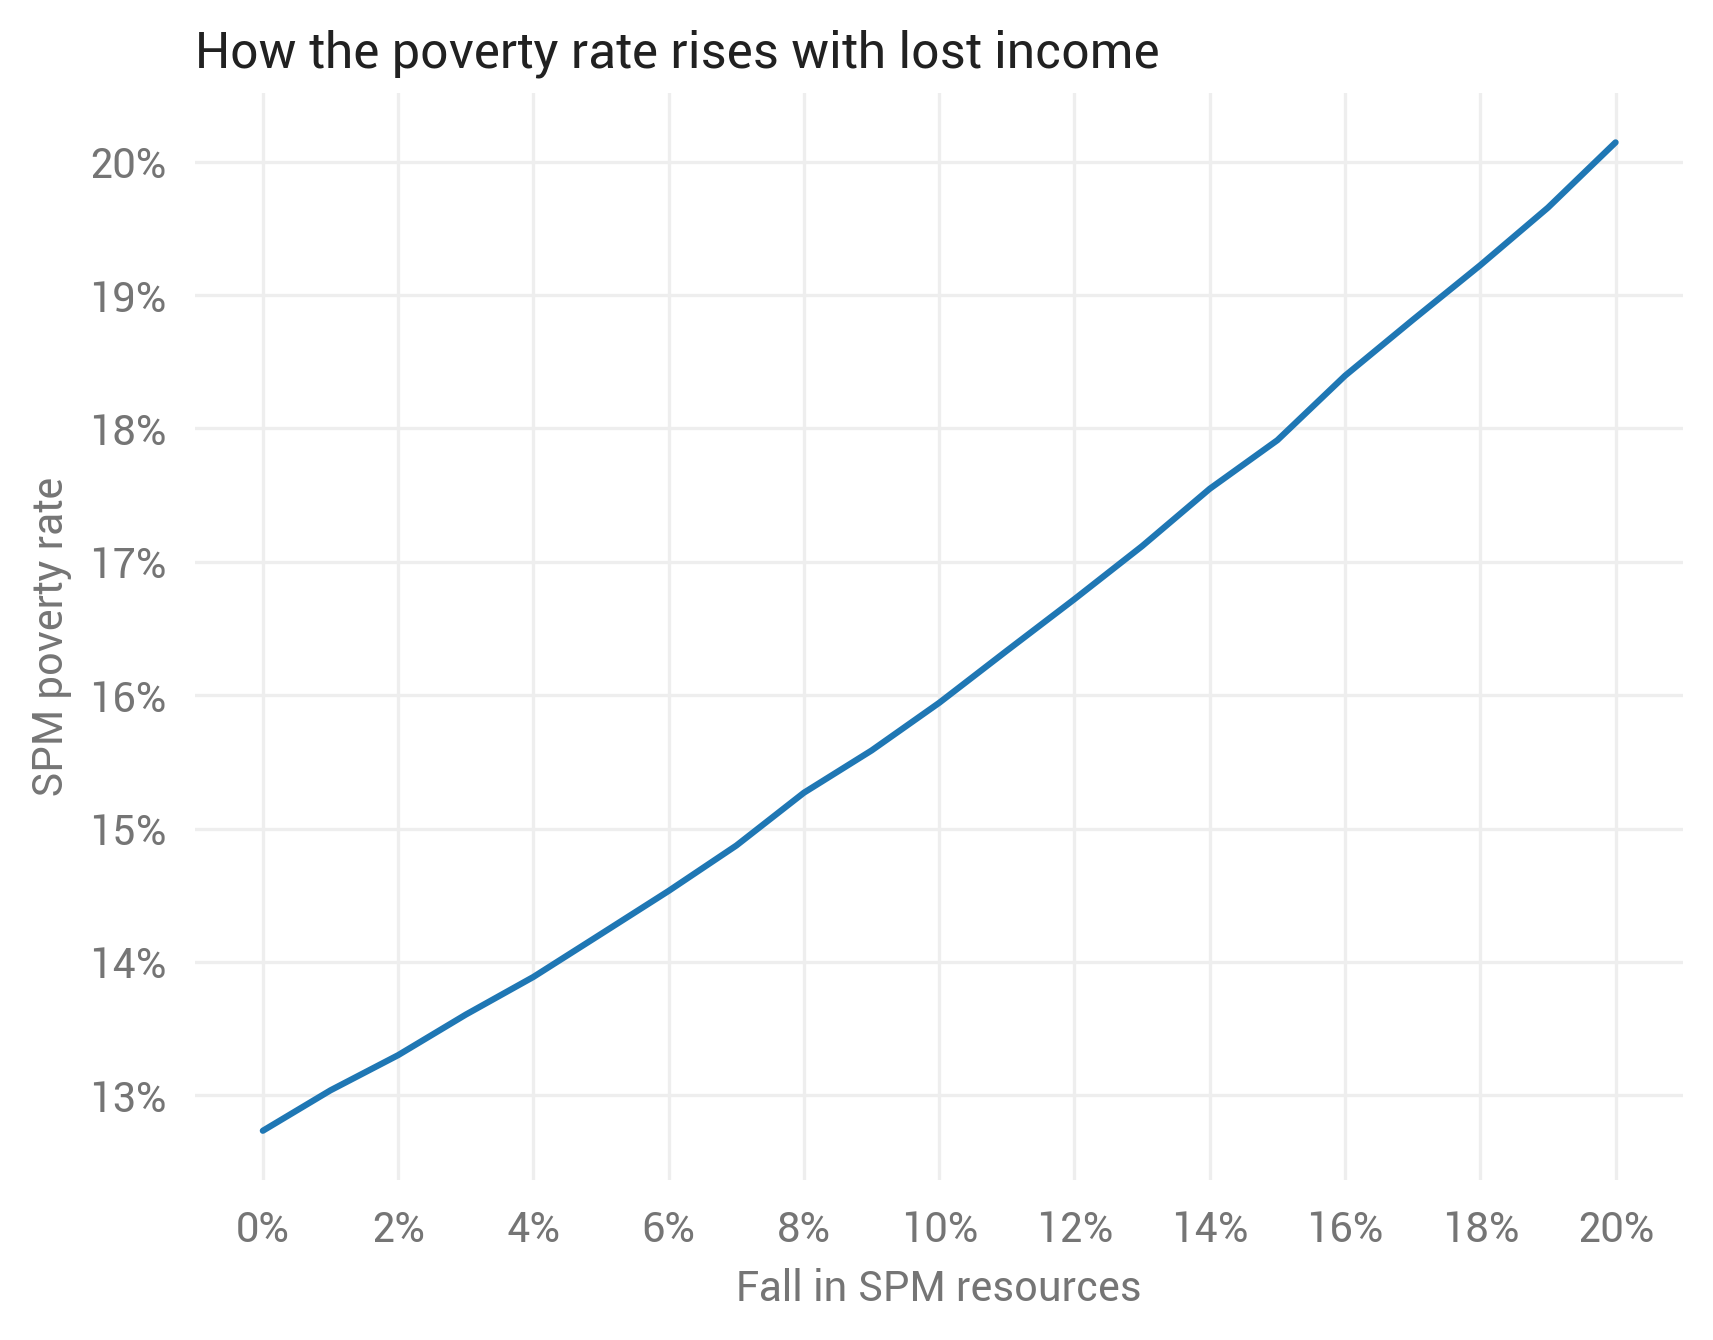

In [40]:
ax = cuts.pov_rate.plot()
plt.title('How the poverty rate rises with lost income', loc='left')
plt.xticks(np.arange(0, 0.21, 0.02))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel('Fall in SPM resources')
plt.ylabel('SPM poverty rate')
plt.savefig('charts/pov_rate_income.png')
plt.show()

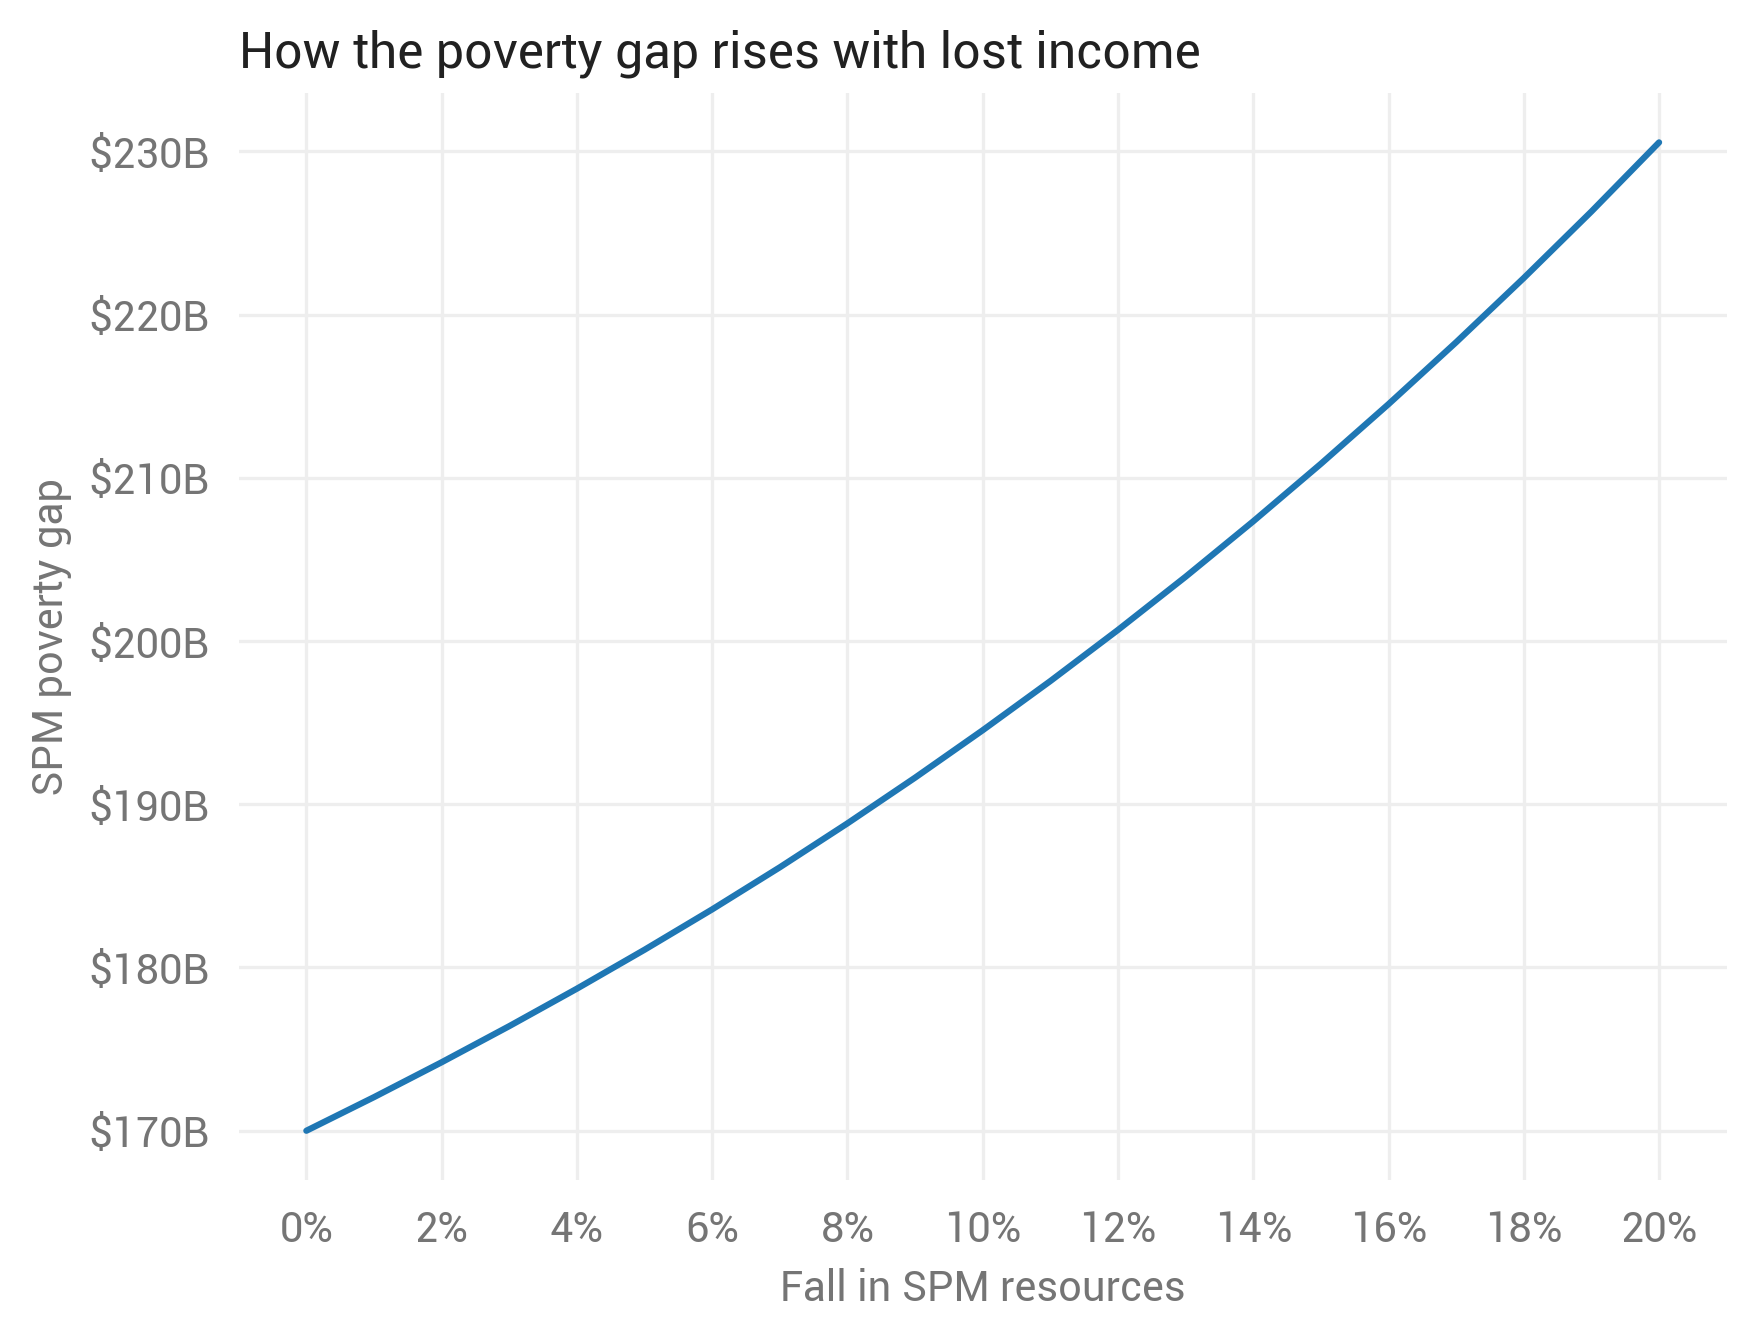

In [41]:
ax = cuts.pov_gap_b.plot()
plt.title('How the poverty gap rises with lost income', loc='left')
plt.xticks(np.arange(0, 0.21, 0.02))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format('B'))
plt.xlabel('Fall in SPM resources')
plt.ylabel('SPM poverty gap')
plt.savefig('charts/pov_gap_income.png')
plt.show()

Compared to baseline.

In [42]:
cuts - cuts.iloc[0]

,pov_rate,pov_gap_b,pov_m
0.00,0.000000,0.000000,0.000000
0.01,0.003032,2.058236,0.991927
0.02,0.005668,4.194937,1.854696
0.03,0.008708,6.409913,2.849103
0.04,0.011534,8.705166,3.773821
0.05,0.014754,11.090481,4.827511
0.06,0.017985,13.563987,5.884806
0.07,0.021385,16.142045,6.997185
0.08,0.025349,18.834945,8.294208
0.09,0.028515,21.635127,9.330175


In [43]:
cuts / cuts.iloc[0]

,pov_rate,pov_gap_b,pov_m
0.00,1.000000,1.000000,1.000000
0.01,1.023808,1.012108,1.023808
0.02,1.044515,1.024678,1.044515
0.03,1.068382,1.037708,1.068382
0.04,1.090577,1.051210,1.090577
0.05,1.115867,1.065242,1.115867
0.06,1.141243,1.079793,1.141243
0.07,1.167942,1.094959,1.167942
0.08,1.199072,1.110800,1.199072
0.09,1.223936,1.127273,1.223936


## With UBI

### 10 percent example

In [44]:
ubi_10pct_example = pd.DataFrame(index=np.arange(0, 2000, 10))

In [45]:
ubi_10pct_example['pov_all'] = ubi_10pct_example.index.map(
    lambda x: ubi_pov_rate(resource_cut=0.1, ubi_adult=x, ubi_kid_share=1,
                           include_noncitizens=True))
ubi_10pct_example['pov_adult_citizens'] = ubi_10pct_example.index.map(
    lambda x: ubi_pov_rate(resource_cut=0.1, ubi_adult=x, ubi_kid_share=0,
                           include_noncitizens=False))

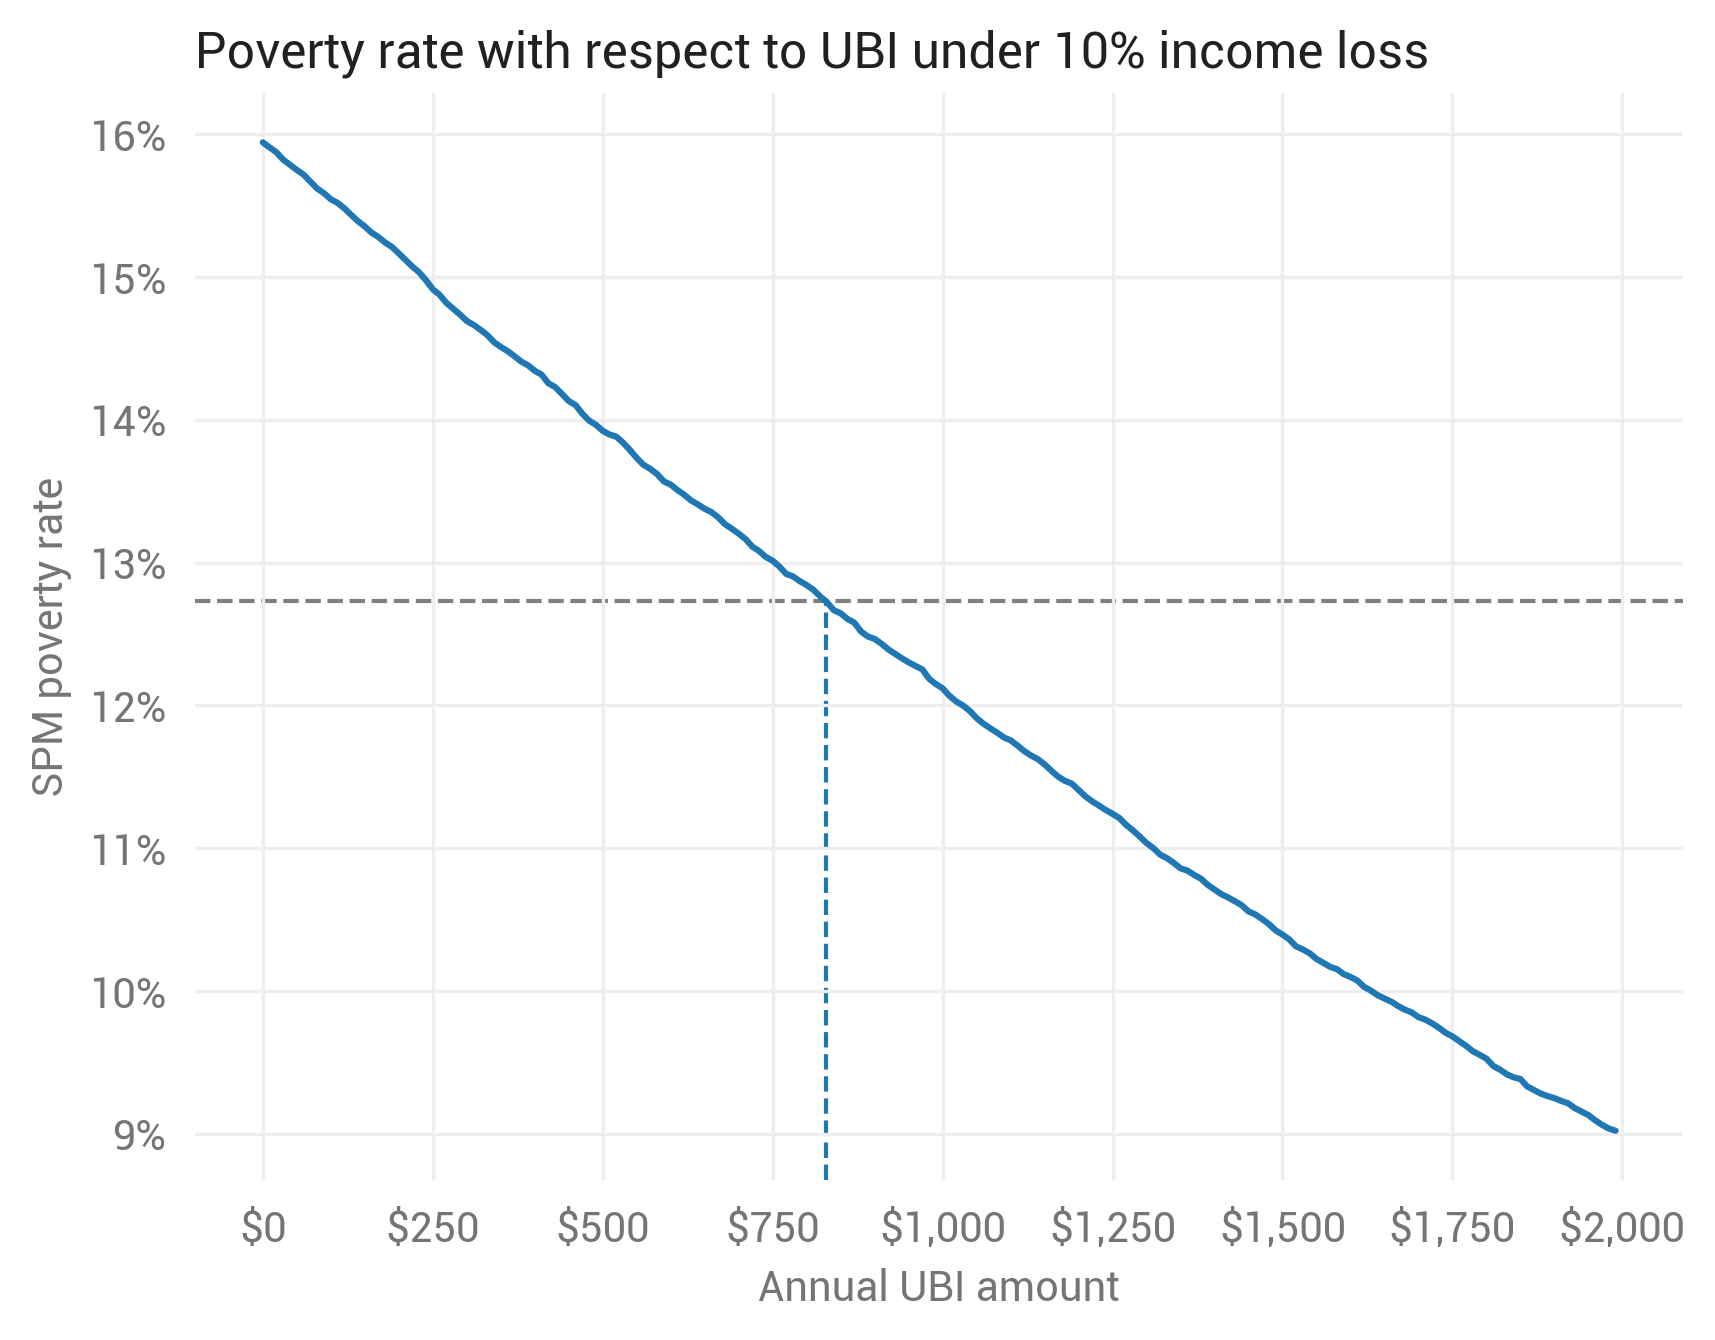

In [46]:
ax = ubi_10pct_example.pov_all.plot()
plt.title('Poverty rate with respect to UBI under 10% income loss',
          loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
# Show current poverty rate.
plt.axhline(ubi_pov_rate(), color='gray', lw=1, ls='--', zorder=-1)
# TODO: Figure out how to automate this.
# TODO: Add annotation saying it's the current poverty rate.
plt.axvline(828, ymax=0.53, lw=1, ls='--', zorder=-1)
plt.xlabel('Annual UBI amount')
plt.ylabel('SPM poverty rate')
plt.savefig('charts/pov_rate_by_ubi_10pct_all.png')
plt.show()

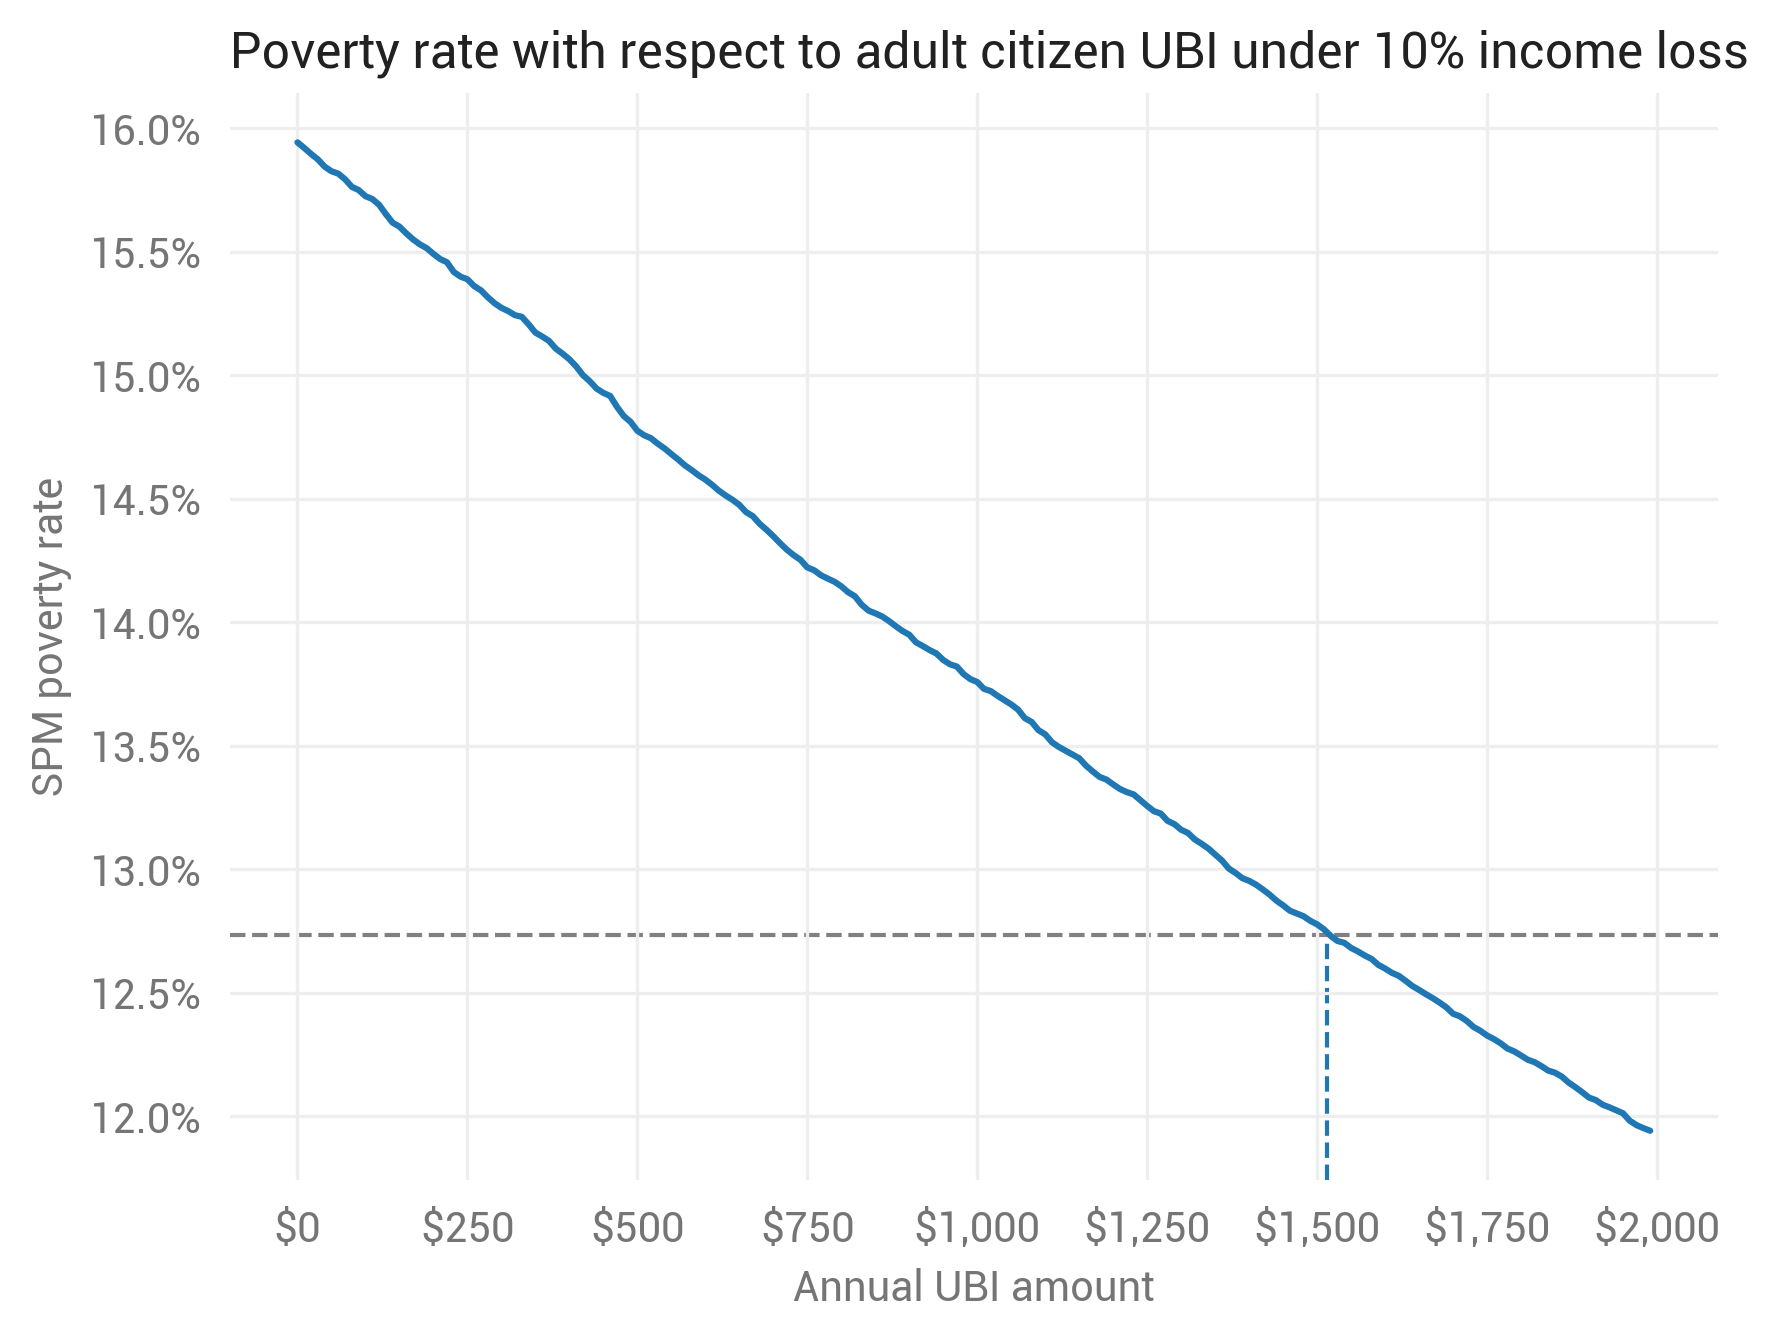

In [47]:
ax = ubi_10pct_example.pov_adult_citizens.plot()
plt.title('Poverty rate with respect to adult citizen UBI under 10% income' +
          ' loss', loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=1))
# Show current poverty rate.
plt.axhline(ubi_pov_rate(), color='gray', lw=1, ls='--', zorder=-1)
# TODO: Figure out how to automate this.
plt.axvline(1515, ymax=0.22, lw=1, ls='--', zorder=-1)
plt.xlabel('Annual UBI amount')
plt.ylabel('SPM poverty rate')
plt.savefig('charts/pov_rate_by_ubi_10pct_adult_citizens.png')
plt.show()

### Generate data

In [48]:
def mid(left, right):
    return (left + right) / 2

def binary_search_opt(f, left, right, tol, max_runs=100, verbose=False):
    """ Finds the value of a monotonically increasing function that comes
        closest to zero, using binary search.
        
    Args:
        f: Monotonically increasing function with respect to its single
            argument.
        left: Minimum value at which f is evaluated.
        right: Maximum value at which f is evaluated.
        tol: Tolerance. Function stops searching once a value within tol
            of zero is identified.
        max_runs: Maximum number of loops to evaluate. Defaults to 100.
        verbose: Whether to print the results of each loop. Defaults to False.
        
    Returns:
        First value in the binary search algorithm for which f evaluates
            within tol of zero.
    """
    # Start at the midpoint.
    val = mid(left, right)
    delta = f(val)
    i = 1
    while np.abs(delta) > tol and i < max_runs:
        if verbose:
            print('left: ' + str(round(left, 3)) + 
                  ', right: ' + str(round(right, 3)) +
                  ', val: ' + str(round(val, 3)) +
                  ', delta: ' + str(round(delta, 3)))
        if delta < 0:
            left = val
        else:
            right = val
        val = mid(left, right)
        delta = f(val)
        i = i + 1
    return val

Create backbone of a data frame to fill in.

In [49]:
ubis = mdf.cartesian_product({'cut': CUTS,
                              'kid_share': [0, 0.5, 1],
                              'include_noncitizens': [False, True]
                             })

Find the UBI that keeps the poverty rate from rising for each scenario.

**TODO: Make this a single call with the poverty gap, and put that split in the backbone.**

In [50]:
ubis['pov_rate_ubi'] = ubis.apply(
    lambda row: binary_search_opt(
        lambda x: ubi_pov_rate() - ubi_pov_rate(row.cut, x, row.kid_share,
                                                row.include_noncitizens),
        0, 4000, 0.0001), axis=1
).astype(int)

Find the UBI that keeps the poverty gap from rising for each scenario.

In [51]:
ubis['pov_gap_ubi'] = ubis.apply(
    lambda row: binary_search_opt(
        lambda x: ubi_pov_gap_b() - ubi_pov_gap_b(
            row.cut, x, row.kid_share, row.include_noncitizens),
        0, 4000, 0.0001), axis=1
).astype(int)

Calculate cost.

In [52]:
ubis['pov_rate_ubi_cost_b'] = ubis.apply(
    lambda row: ubi_cost_b(row.pov_rate_ubi, row.kid_share,
                           row.include_noncitizens), axis=1).astype(int)
ubis['pov_gap_ubi_cost_b'] = ubis.apply(
    lambda row: ubi_cost_b(row.pov_gap_ubi, row.kid_share,
                           row.include_noncitizens), axis=1).astype(int)

Add a single label based on `kid_share` and `include_noncitizens` for graphing.

In [53]:
ubis['label'] = np.where(ubis.include_noncitizens,
                         np.where(ubis.kid_share == 0, 'Adults',
                                  np.where(ubis.kid_share == 0.5,
                                           'Adults + half share for kids',
                                           'Everyone')),
                         np.where(ubis.kid_share == 0, 'Adult citizens',
                                  np.where(ubis.kid_share == 0.5,
                                           'Adult citizens + half share for' +
                                           ' kids',
                                           'All citizens')))

### 10% income loss

As an illustrative example.

In [54]:
ubis[ubis.cut == 0.1].set_index('label').drop(
    ['cut', 'kid_share', 'include_noncitizens'], axis=1)

,pov_rate_ubi,pov_gap_ubi,pov_rate_ubi_cost_b,pov_gap_ubi_cost_b
label,,,,
Adult citizens,1515,836,347,191
Adults,1250,691,313,173
Adult citizens + half share for kids,1203,703,318,186
Adults + half share for kids,1000,594,287,170
All citizens,968,610,291,183
Everyone,828,523,268,169


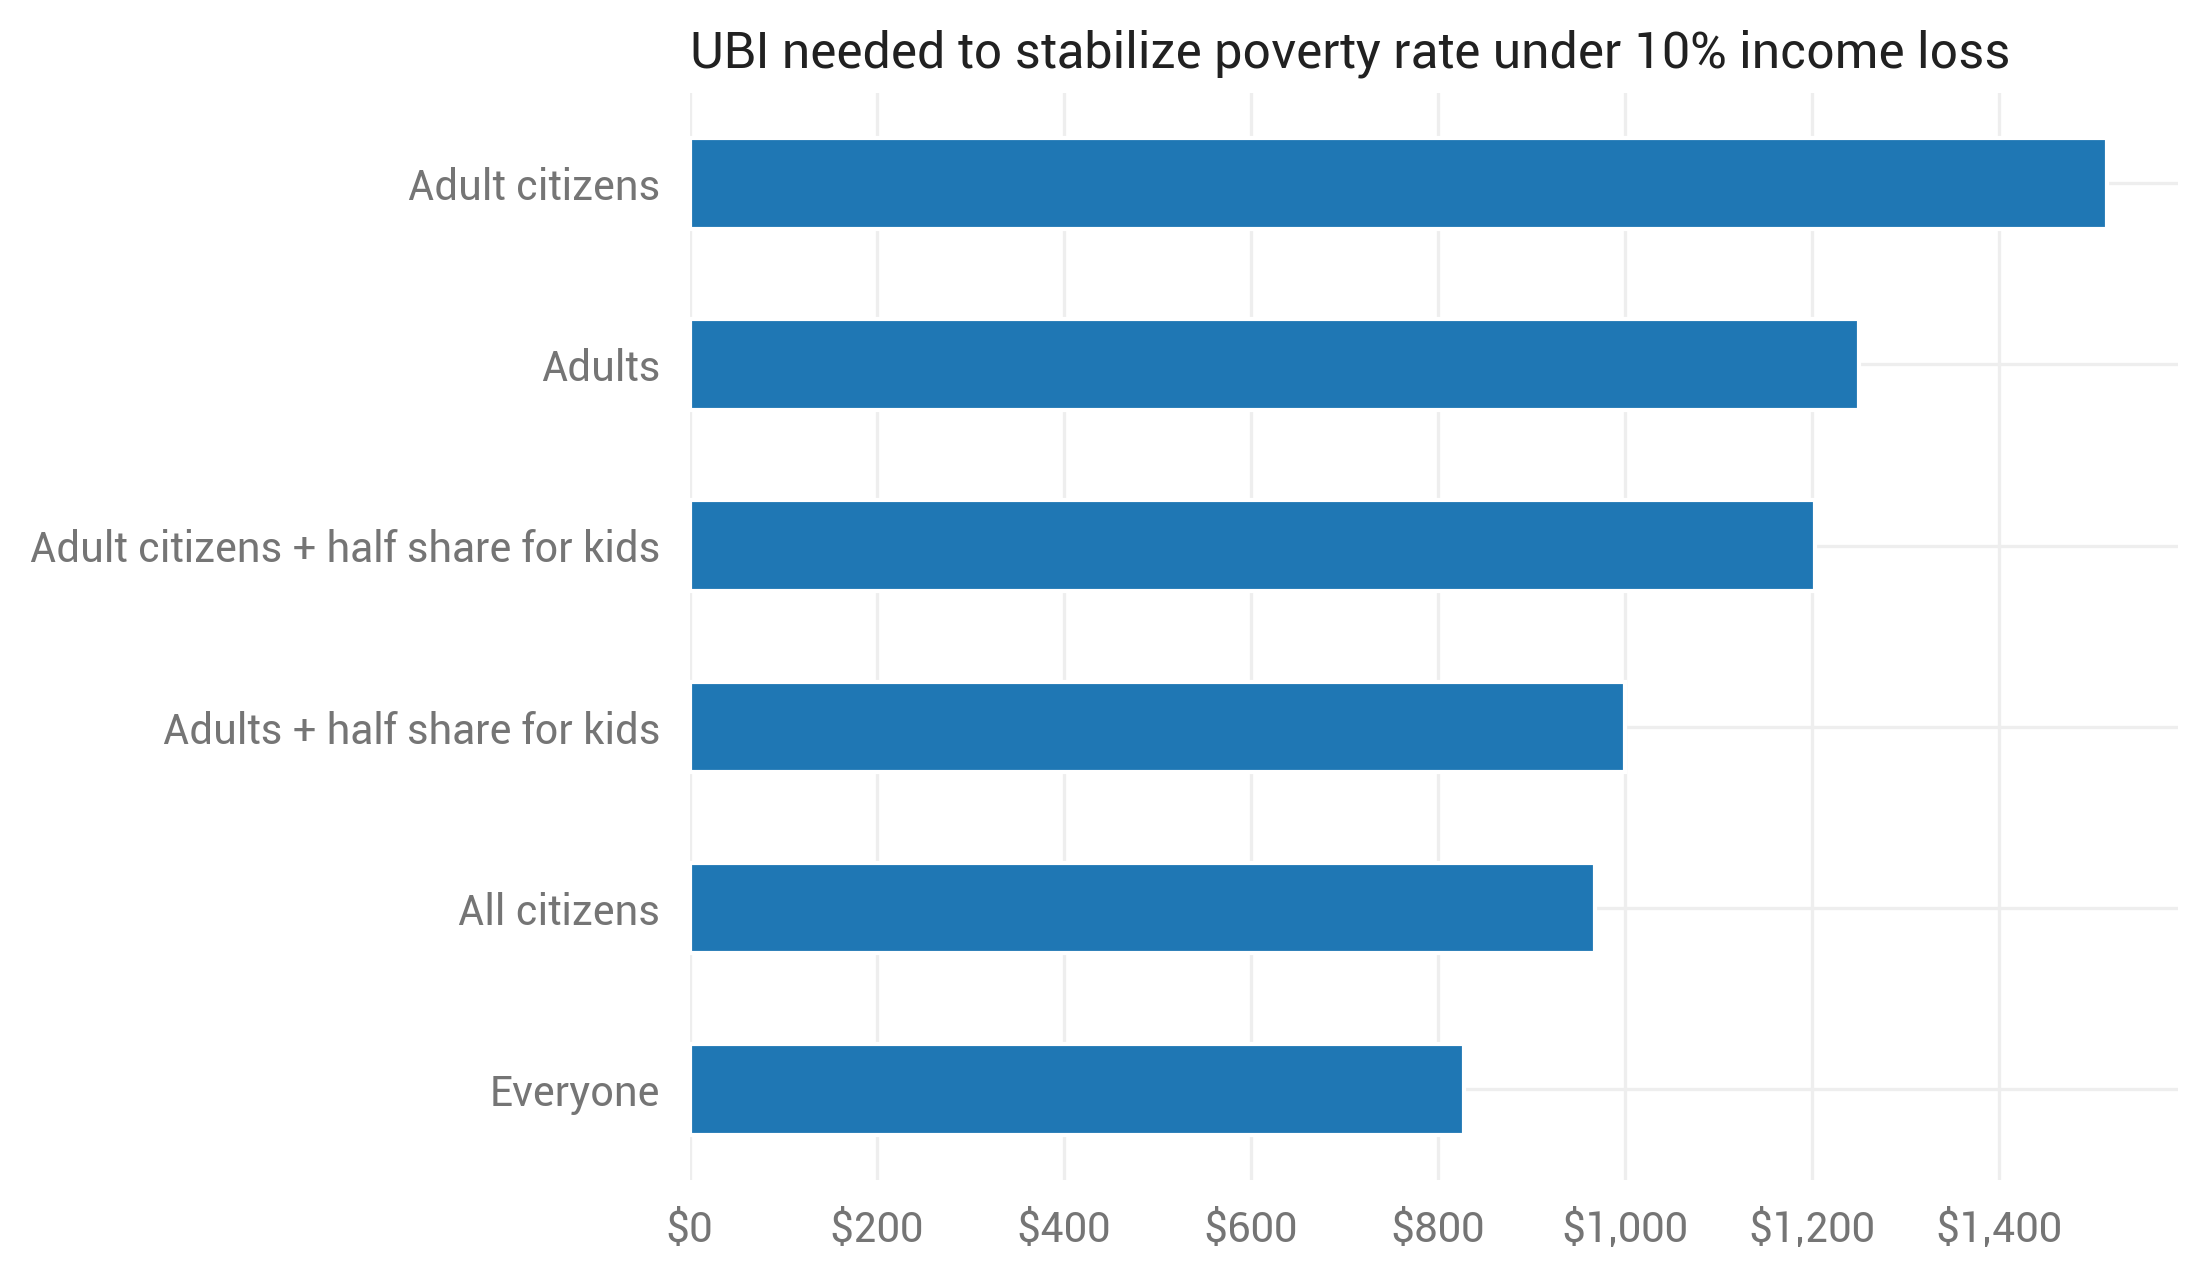

In [55]:
ax = ubis[ubis.cut == 0.1].sort_values('pov_rate_ubi').plot.barh(
    'label', 'pov_rate_ubi')
plt.title('UBI needed to stabilize poverty rate under 10% income loss',
          loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('')
ax.get_legend().remove()
# Use tight bbox to avoid left labels getting cut off.
plt.savefig('charts/ubi_pov_rate_10pct.png', bbox_inches='tight')
plt.show()

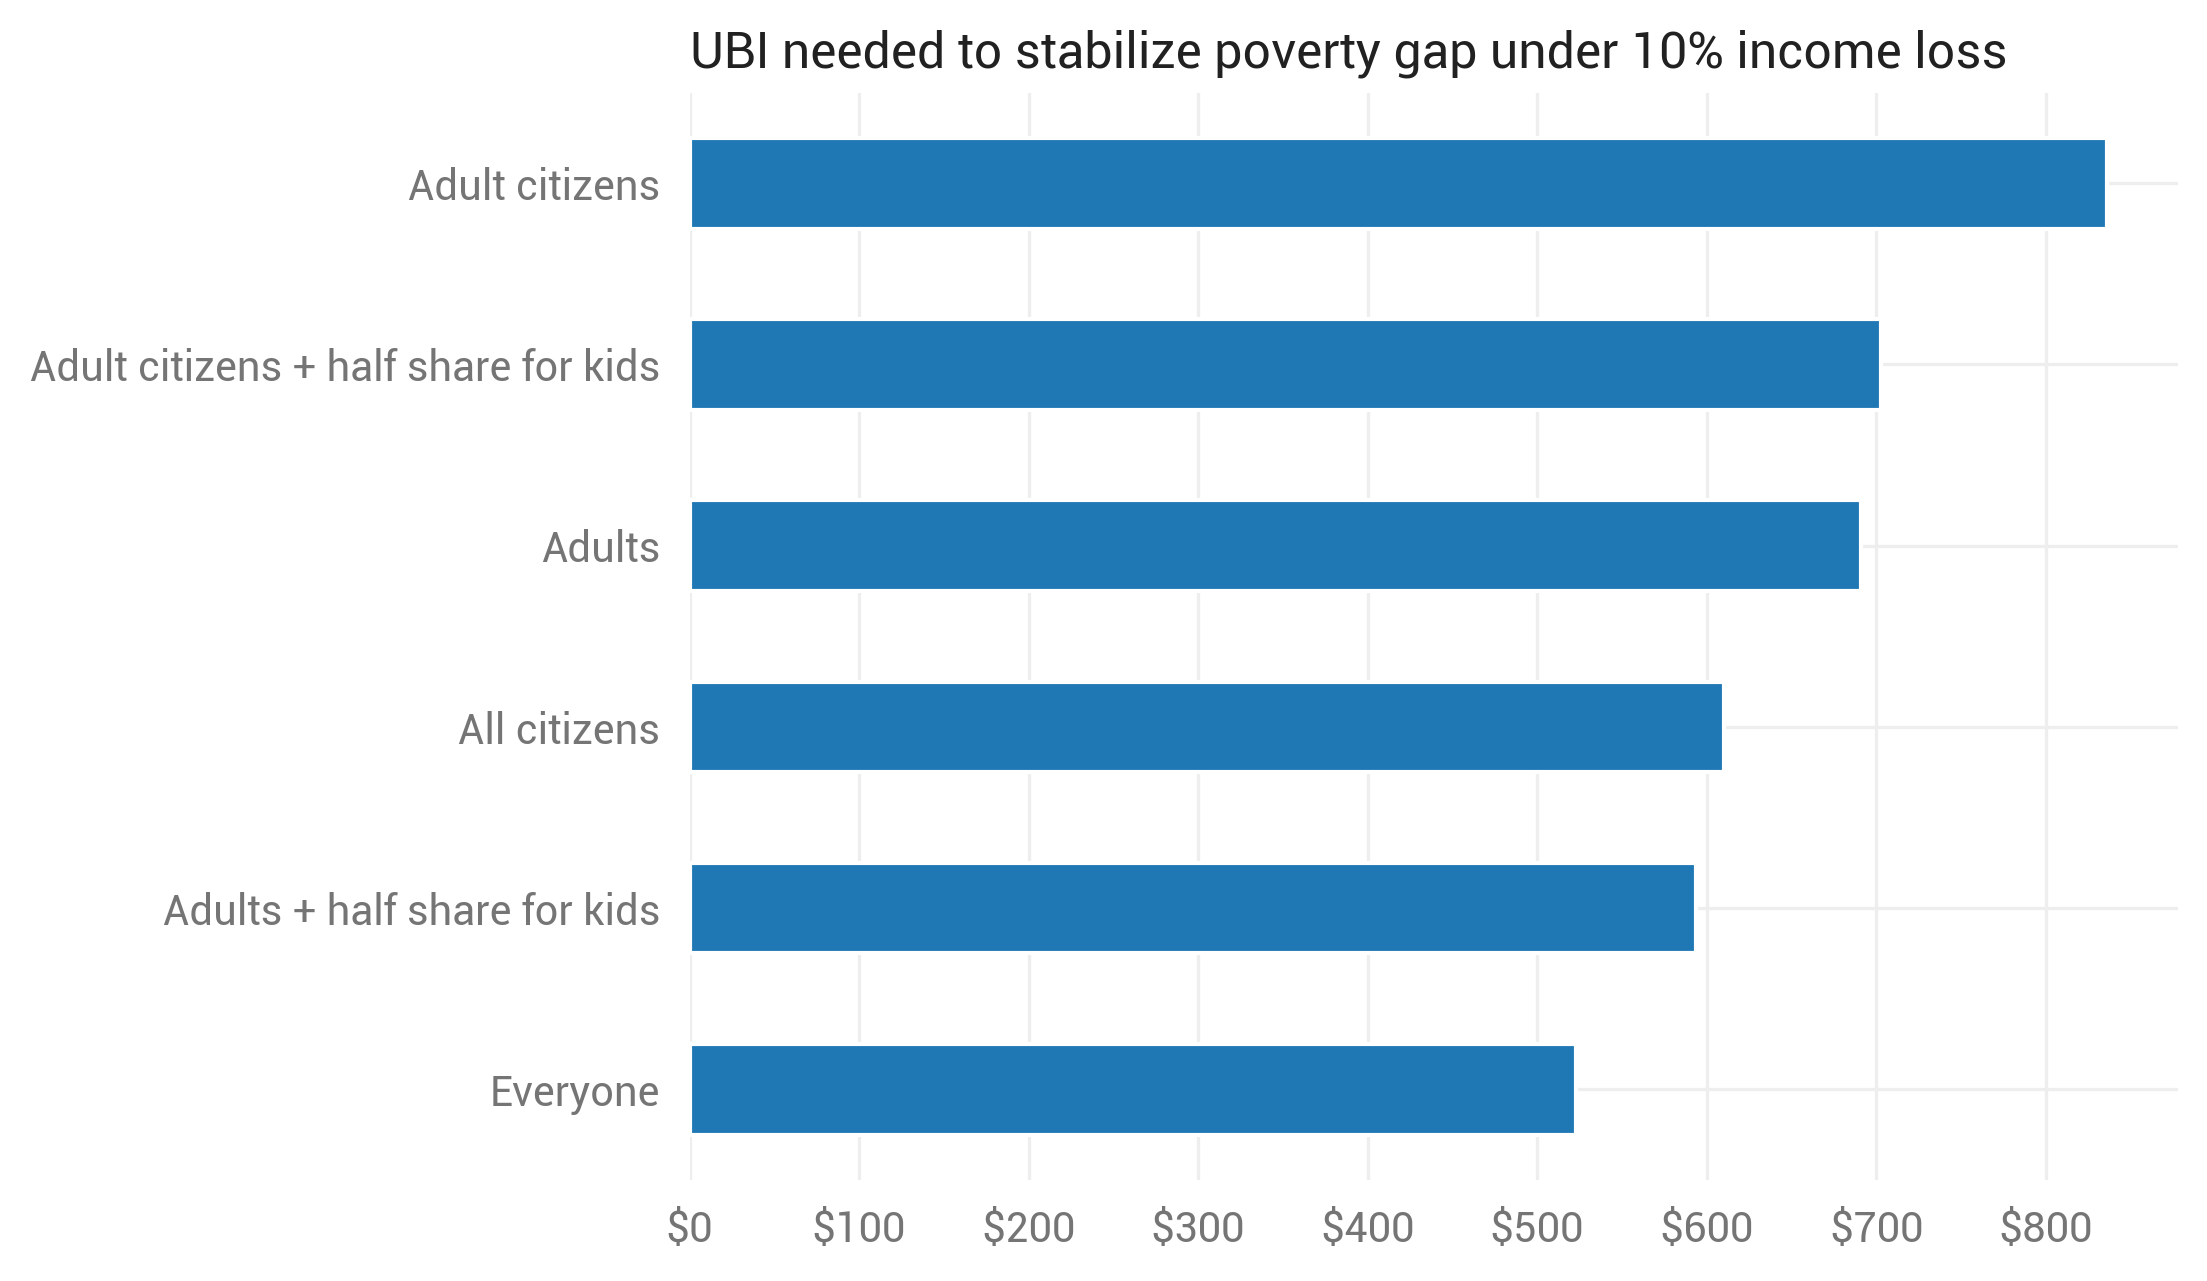

In [56]:
ax = ubis[ubis.cut == 0.1].sort_values('pov_gap_ubi').plot.barh(
    'label', 'pov_gap_ubi')
plt.title('UBI needed to stabilize poverty gap under 10% income loss',
          loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('')
ax.get_legend().remove()
plt.savefig('charts/ubi_pov_gap_10pct.png', bbox_inches='tight')
plt.show()

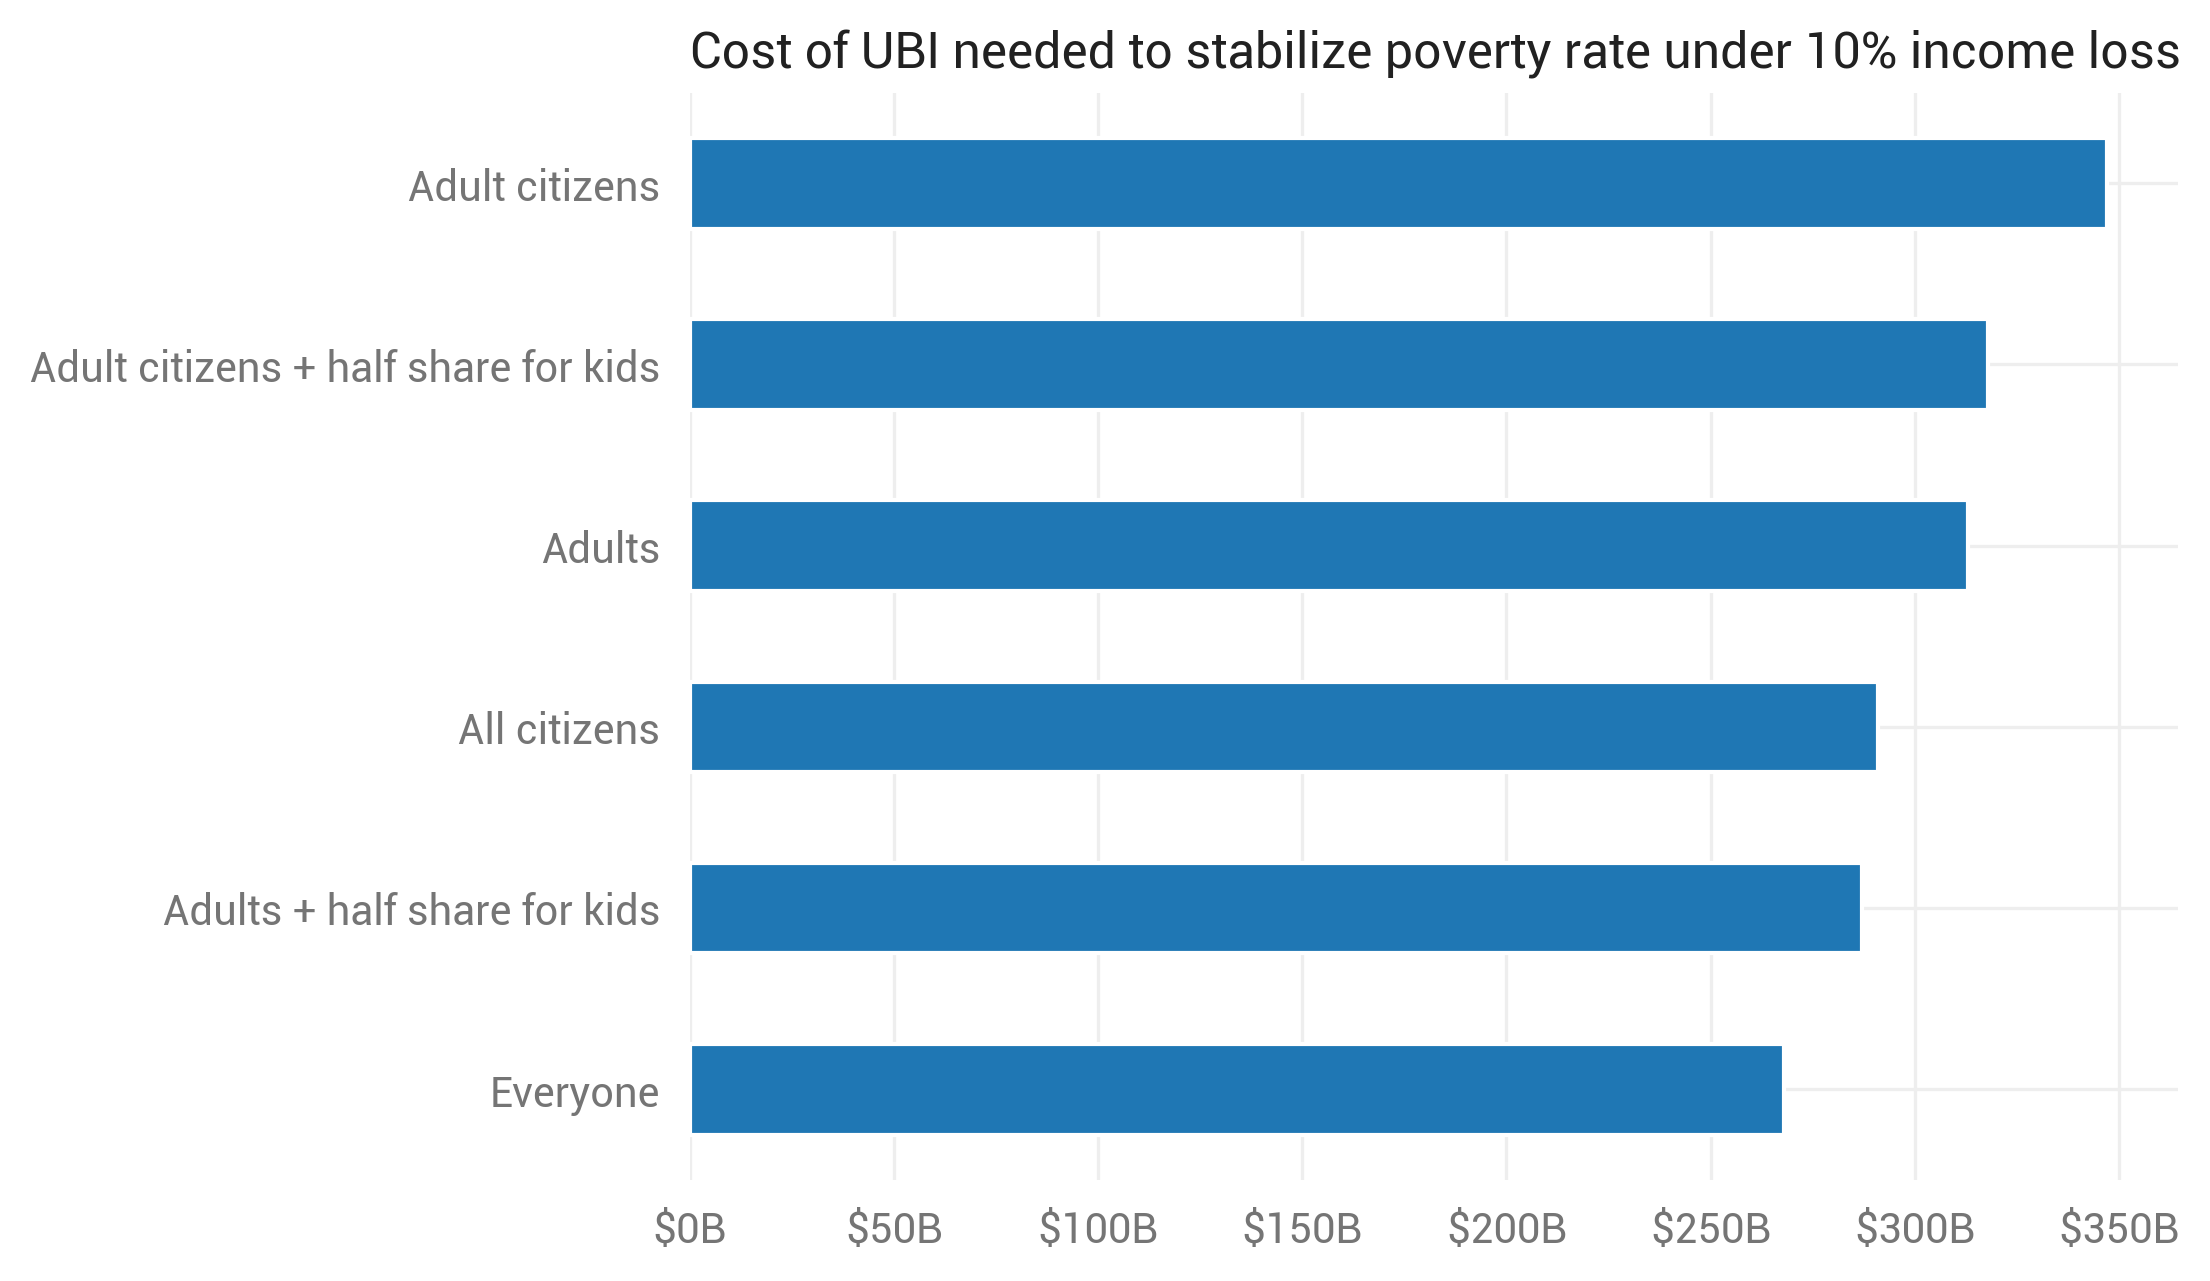

In [57]:
ax = ubis[ubis.cut == 0.1].sort_values('pov_rate_ubi_cost_b').plot.barh(
    'label', 'pov_rate_ubi_cost_b')
plt.title('Cost of UBI needed to stabilize poverty rate under 10% income loss',
          loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format('B'))
plt.ylabel('')
ax.get_legend().remove()
plt.savefig('charts/ubi_cost_pov_rate_10pct.png', bbox_inches='tight')
plt.show()

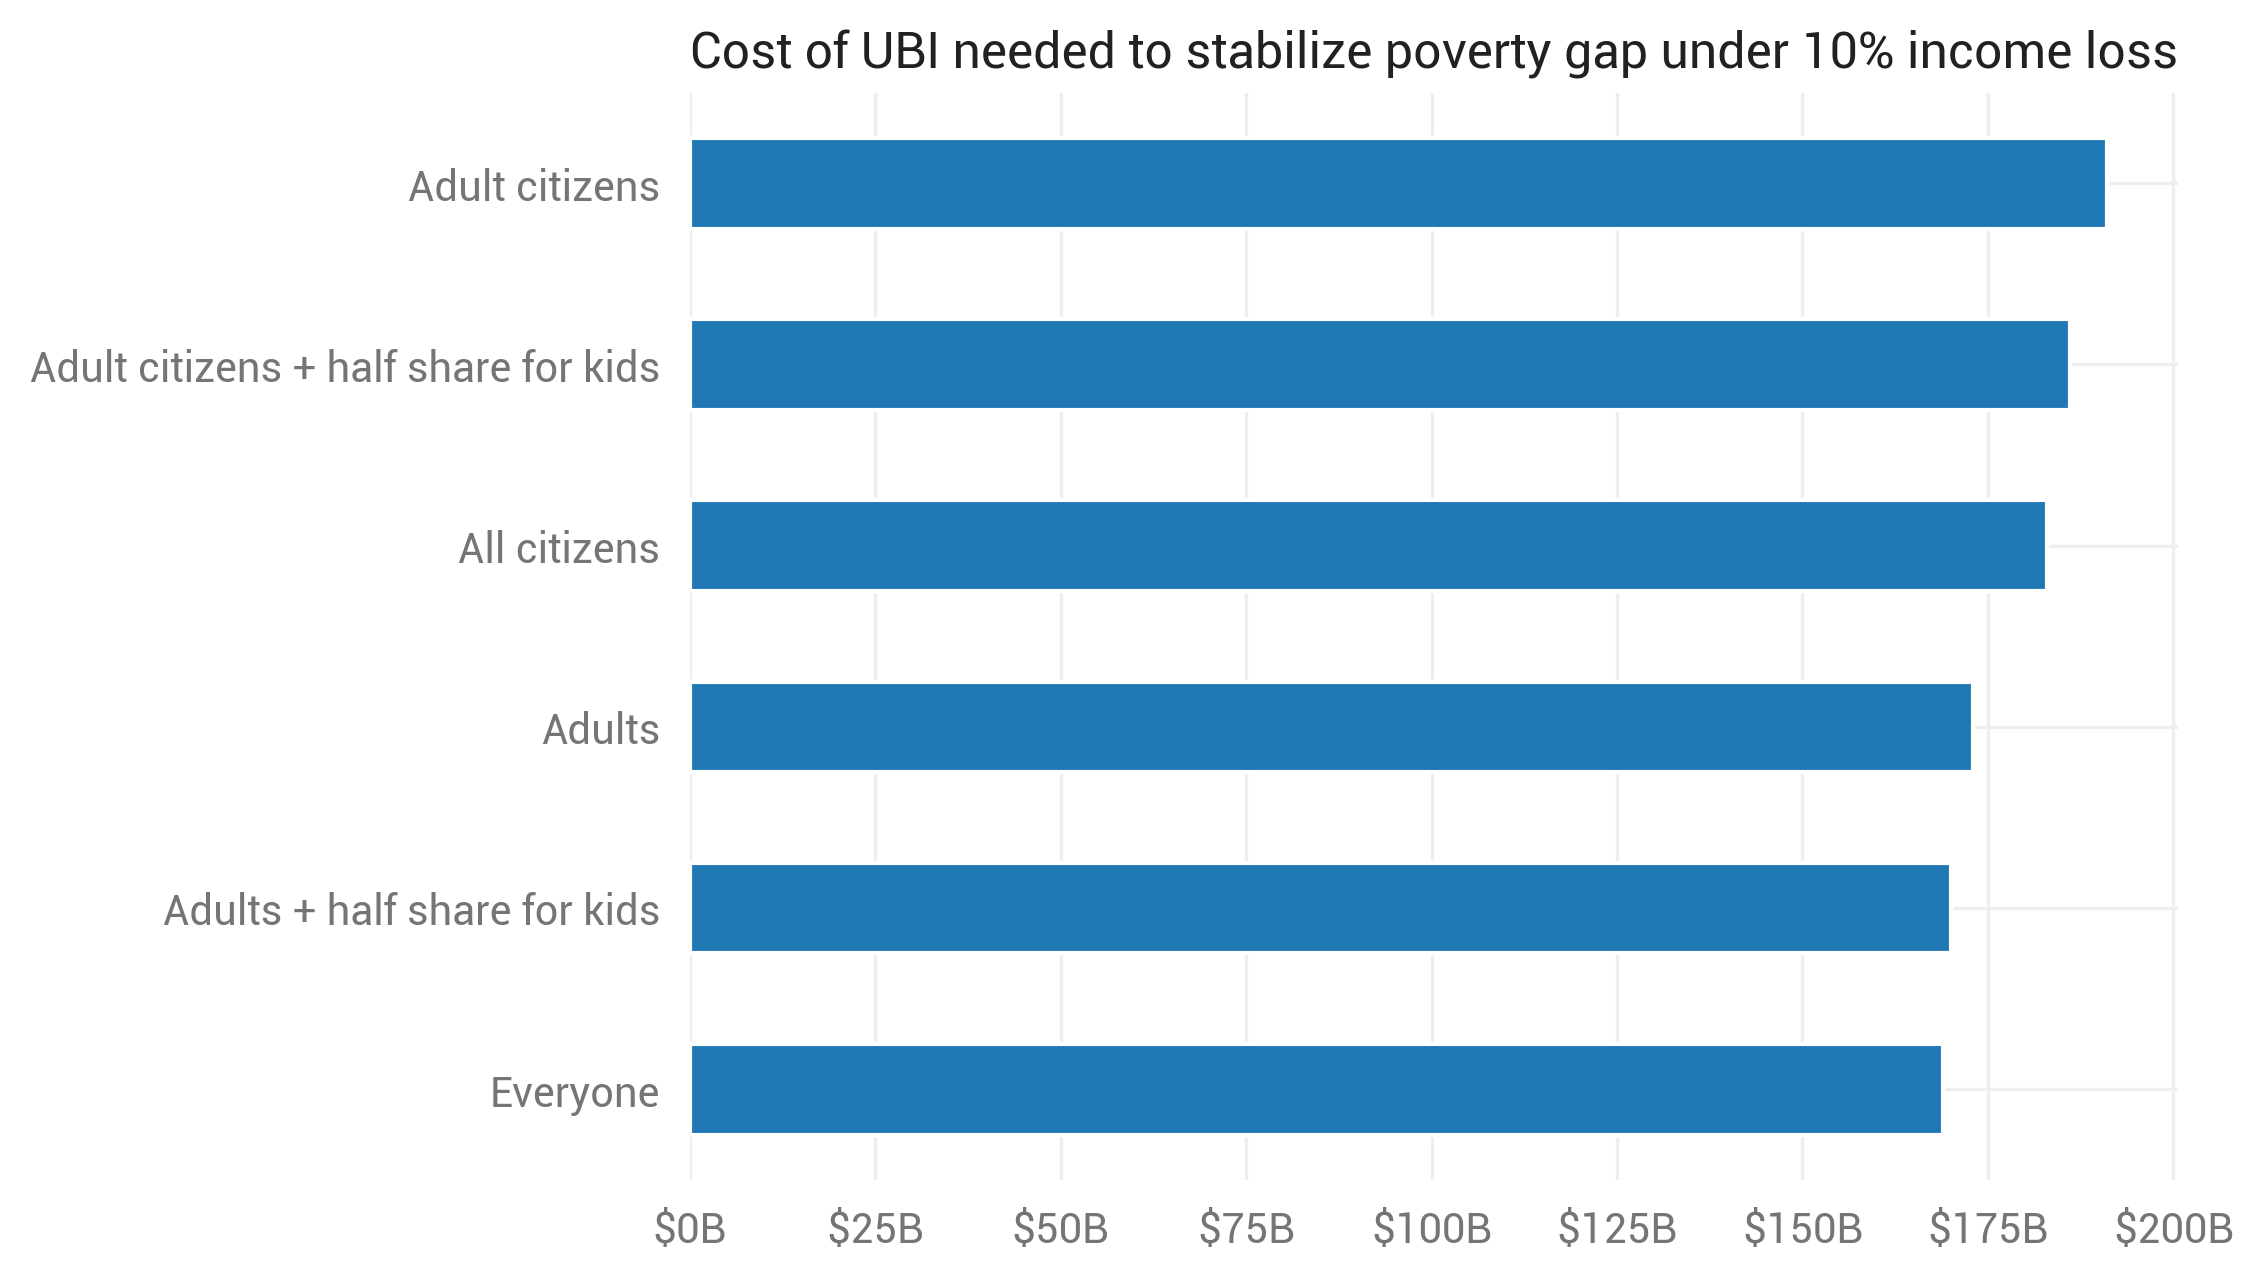

In [58]:
ax = ubis[ubis.cut == 0.1].sort_values('pov_gap_ubi_cost_b').plot.barh(
    'label', 'pov_gap_ubi_cost_b')
plt.title('Cost of UBI needed to stabilize poverty gap under 10% income loss',
          loc='left')
ax.xaxis.set_major_formatter(mdf.dollar_format('B'))
plt.ylabel('')
ax.get_legend().remove()
plt.savefig('charts/ubi_cost_pov_gap_10pct.png', bbox_inches='tight')
plt.show()

### Range of income losses

First pivot the data.

In [59]:
ubis_rate_pivot = ubis.pivot_table(['pov_rate_ubi', 'pov_rate_ubi_cost_b',
                                    'pov_gap_ubi', 'pov_gap_ubi_cost_b'], 
                                   'cut', 'label')

Plot UBI amount and total cost both for keeping the poverty rate and the poverty gap steady.

**TODO: Make a logical color scheme, e.g. blues for everyone and grays for citizens only, shaded by kid treatment.**

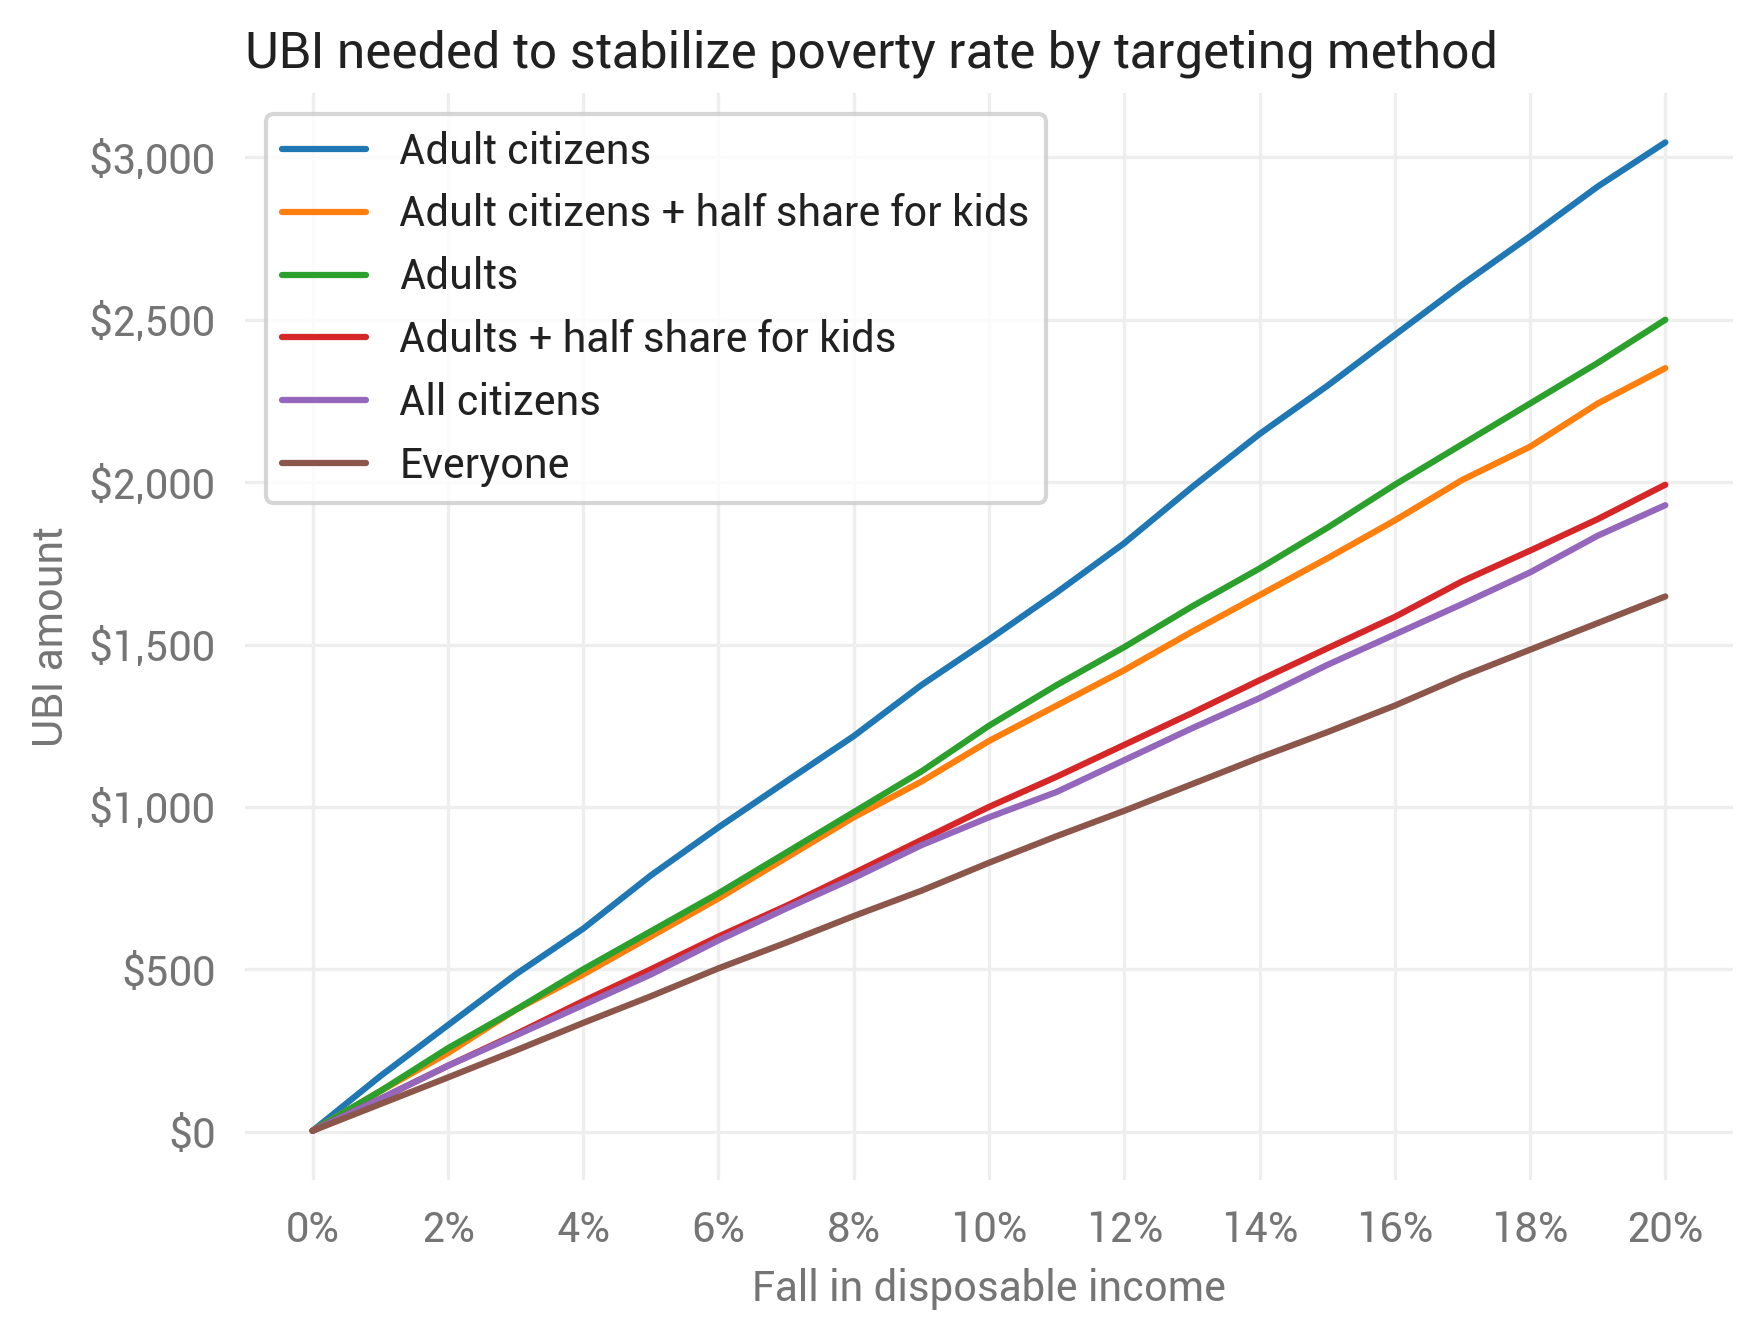

In [60]:
ax = ubis_rate_pivot.pov_rate_ubi.plot.line()
plt.title('UBI needed to stabilize poverty rate by targeting method',
          loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.xticks(np.arange(0, 0.21, 0.02))
plt.legend(title='')
plt.xlabel('Fall in disposable income')
plt.ylabel('UBI amount')
plt.savefig('charts/ubi_pov_rate.png')
plt.show()

**TODO: Make a version of this relative to the "Everyone" line.**

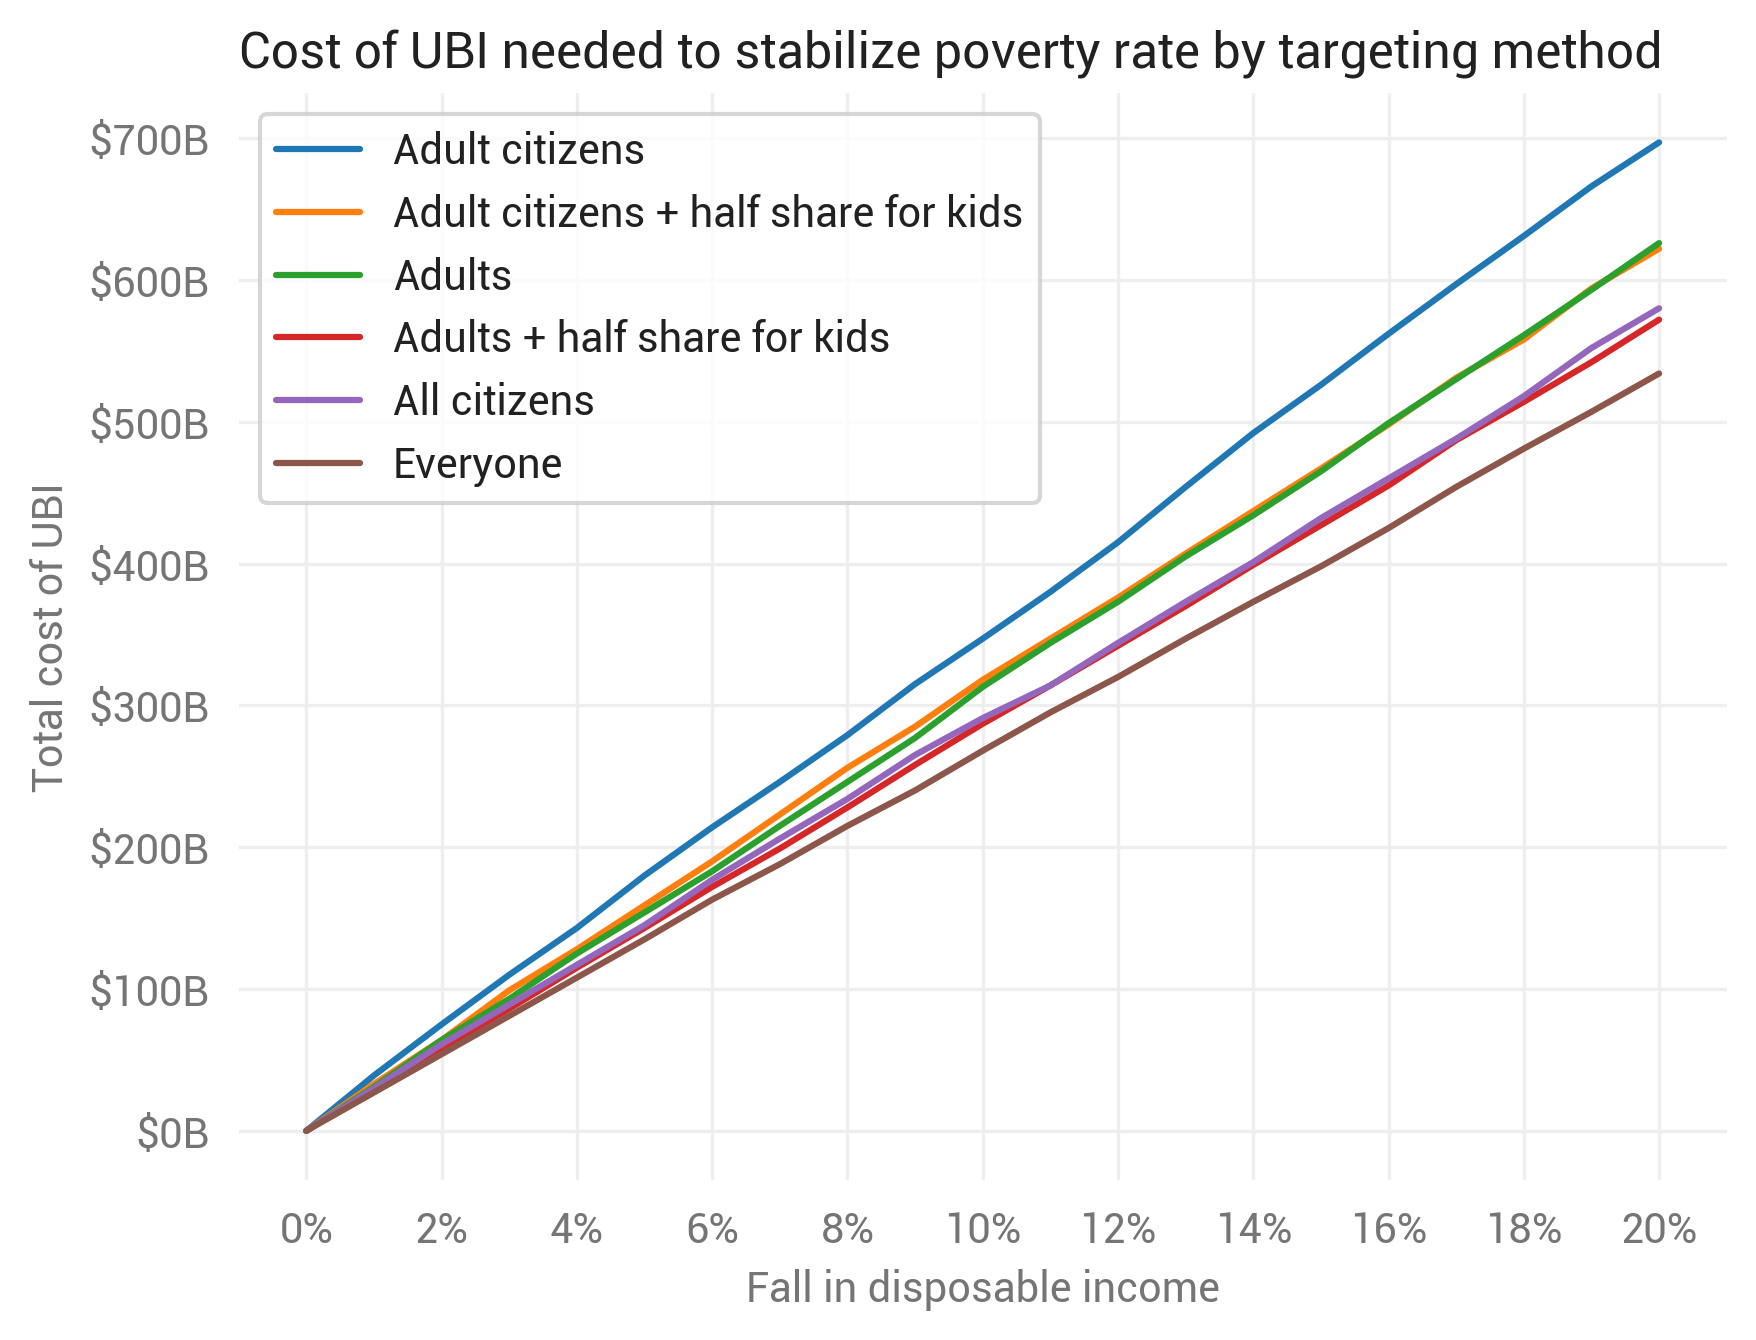

In [61]:
ax = ubis_rate_pivot.pov_rate_ubi_cost_b.plot.line()
plt.title('Cost of UBI needed to stabilize poverty rate by targeting method',
          loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format('B'))
plt.xticks(np.arange(0, 0.21, 0.02))
plt.legend(title='')
plt.xlabel('Fall in disposable income')
plt.ylabel('Total cost of UBI')
plt.savefig('charts/ubi_cost_pov_rate.png')
plt.show()

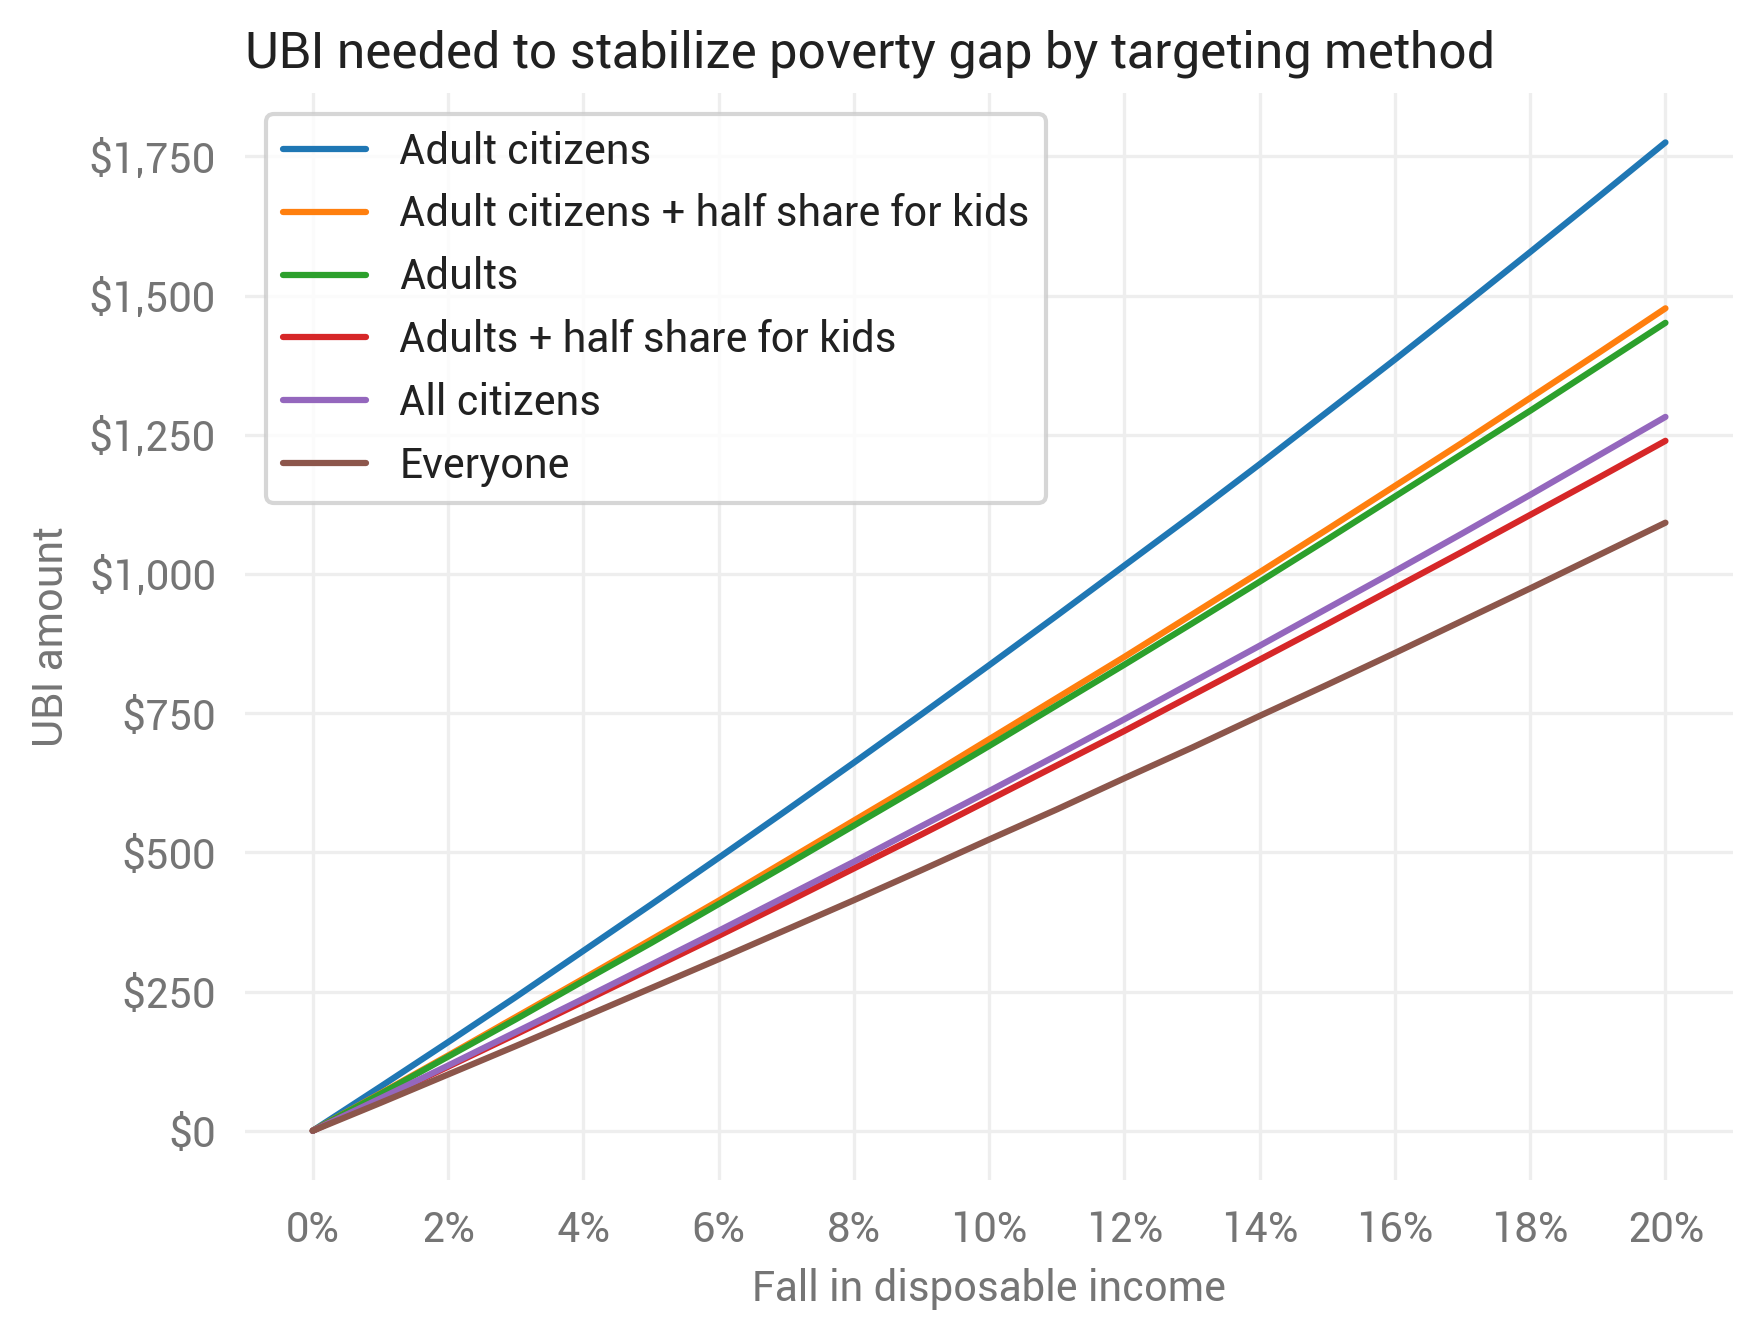

In [62]:
ax = ubis_rate_pivot.pov_gap_ubi.plot.line()
plt.title('UBI needed to stabilize poverty gap by targeting method',
          loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format())
plt.xticks(np.arange(0, 0.21, 0.02))
plt.legend(title='')
plt.xlabel('Fall in disposable income')
plt.ylabel('UBI amount')
plt.savefig('charts/ubi_pov_gap.png')
plt.show()

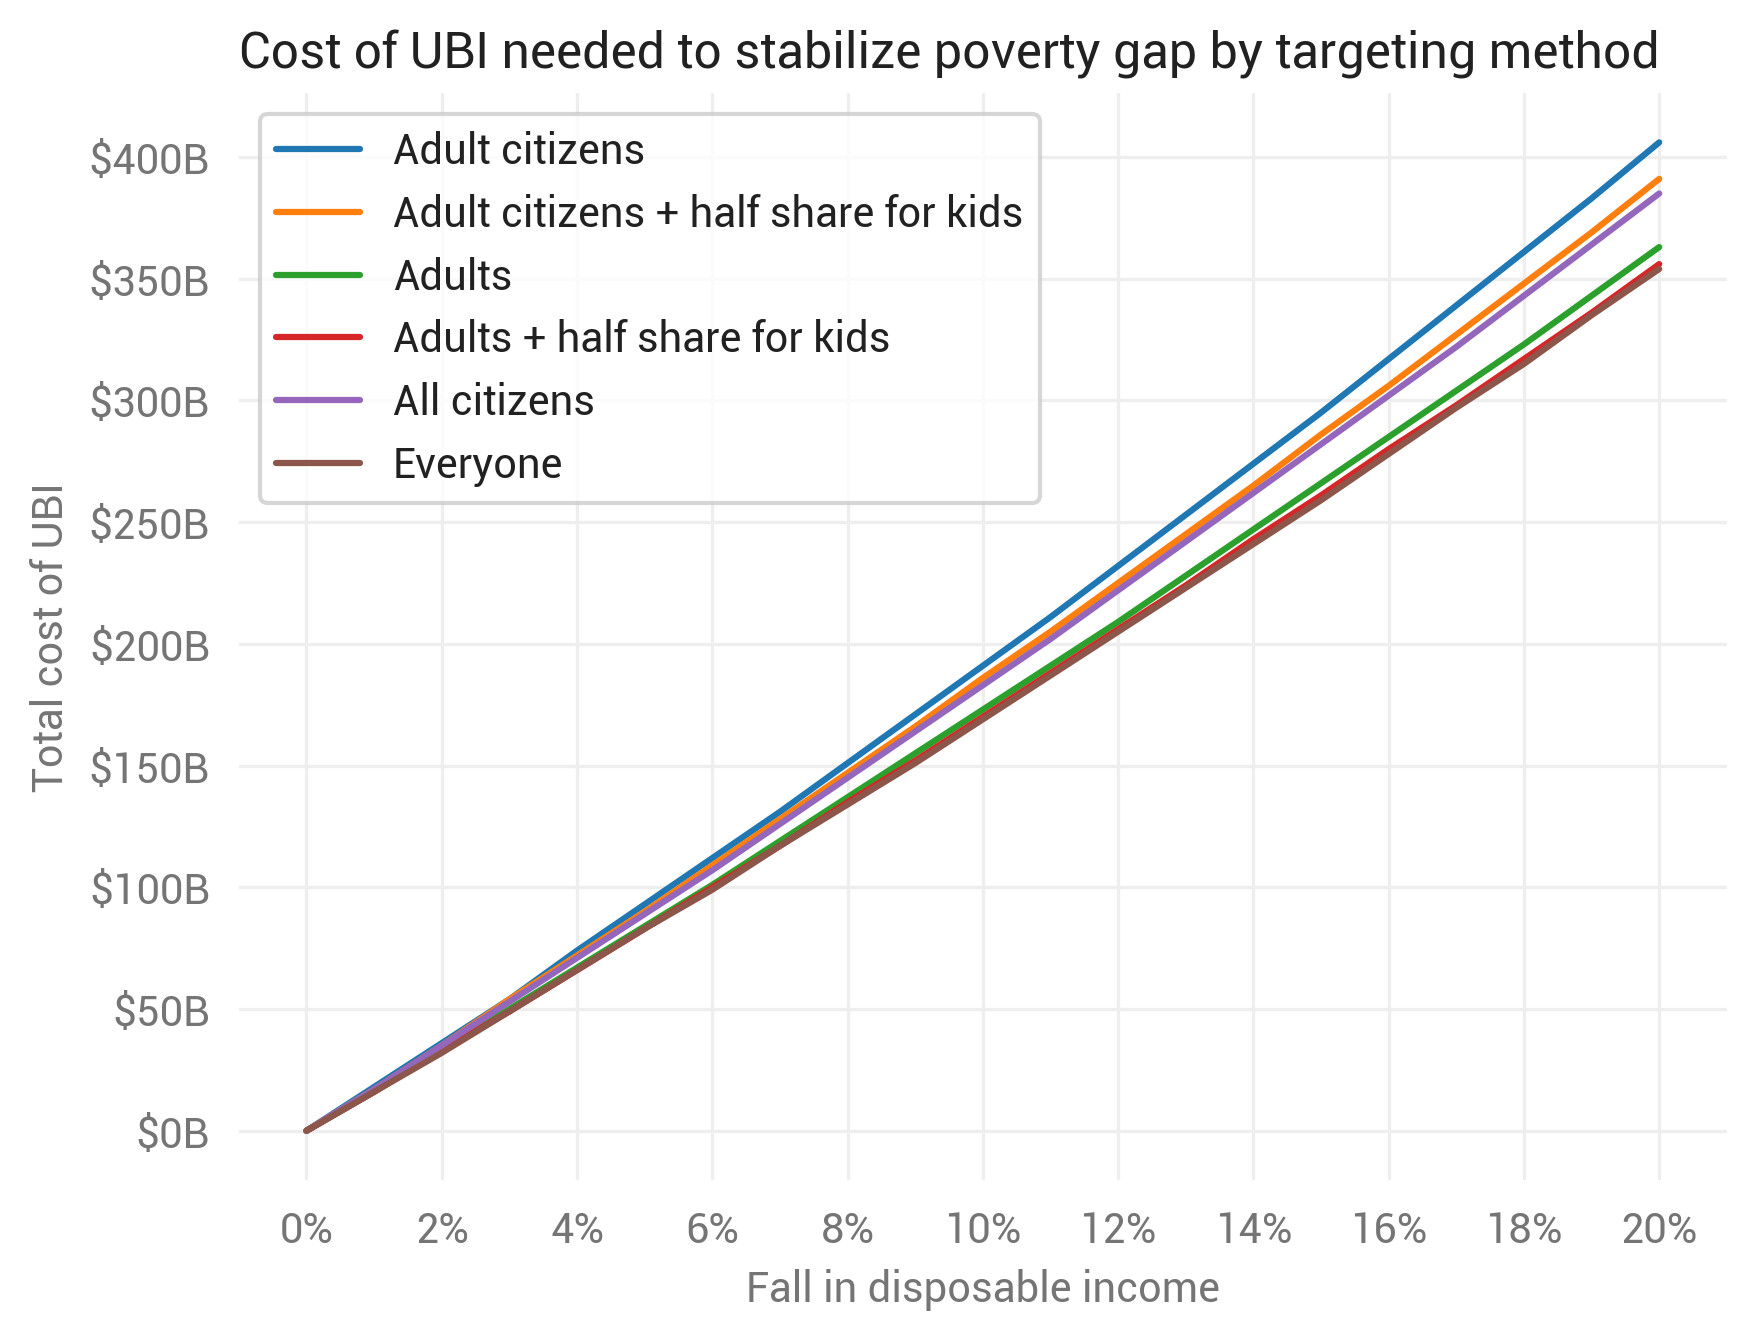

In [63]:
ax = ubis_rate_pivot.pov_gap_ubi_cost_b.plot.line()
plt.title('Cost of UBI needed to stabilize poverty gap by targeting method',
          loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(mdf.dollar_format('B'))
plt.xticks(np.arange(0, 0.21, 0.02))
plt.legend(title='')
plt.xlabel('Fall in disposable income')
plt.ylabel('Total cost of UBI')
plt.savefig('charts/ubi_cost_pov_gap.png')
plt.show()